<a href="https://colab.research.google.com/github/VLCHS/FCNN-for-p_pi0/blob/FCNN/Training_FCNN_p_pi0%26results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Getting Started

In [1]:
!pip install --q wandb
!pip install --q wandb[media]
!pip install --q torch==2.5.1
!pip install --q lightning==2.4.0
!pip install --q featuretools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# necessary code, if wandb doesn't want to login for no reason
import os
os.environ['WANDB_INIT_TIMEOUT'] = '300'
os.environ['WANDB_HTTP_TIMEOUT'] = '300'
os.environ["WANDB__SERVICE_WAIT"] = "300"
os.environ['WANDB_DEBUG'] = 'true'
os.environ['WANDB_CORE_DEBUG'] = 'true'

In [3]:
import os
import sys

import tqdm
import math
import wandb
wandb.require("legacy-service")

import torch
import pylab
import random
import logging
import torchmetrics

import numpy as np
import pandas as pd
import torch.nn as nn
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import featuretools as ft

from scipy import spatial
from random import randint
from scipy.stats import chisquare, kstest
from scipy.optimize import curve_fit
from torchmetrics import MeanAbsoluteError
from torchmetrics import MeanSquaredError
from torchmetrics import R2Score
from sklearn.metrics import root_mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch.loggers import WandbLogger
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import Callback, LearningRateMonitor, ModelCheckpoint

def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    pl.seed_everything(seed)

set_random_seed(42)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


In [4]:
device = "gpu" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using gpu device


In [5]:
from google.colab import files
uploaded = files.upload()

Saving clasdb_pi_0_p.txt to clasdb_pi_0_p.txt


In [6]:
# Load the data Ebeam = [1.64 2.44 5.75 2.04]
df = pd.read_csv('/content/clasdb_pi_0_p.txt', delimiter='\t', header=None)
df.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
df['phi'] = df.phi.apply(lambda x: math.radians(x))
df['cos_phi'] = df['phi'].apply(lambda x: math.cos(x))
df['sin_phi'] = df['phi'].apply(lambda x: math.sin(x))
df['Ebeam'] = df['Ebeam'].round(decimals=2)
df = df.replace({"Ebeam": {2.45: 2.44, 1.65: 1.64}})
df = df[df['dsigma_dOmega'] <= df["dsigma_dOmega"].quantile(0.97)]
df = df[df['error'] <= df["error"].quantile(0.98)]
df = df.drop(df[df['dsigma_dOmega'] == 0].index)
df = df.drop('id', axis=1)
df = df.reset_index(drop=True)
df = df.iloc[df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
df = df.reset_index(drop=True)
df

,Ebeam,W,Q2,cos_theta,phi,dsigma_dOmega,error,cos_phi,sin_phi
0,1.64,1.1000,0.40,-0.9,0.261799,0.912000,0.982353,0.965926,0.258819
1,1.64,1.1000,0.40,-0.9,0.785398,0.175000,0.356108,0.707107,0.707107
2,1.64,1.1000,0.40,-0.9,1.308997,1.650000,2.769879,0.258819,0.965926
3,1.64,1.1000,0.40,-0.9,1.832596,0.560000,0.979330,-0.258819,0.965926
4,1.64,1.1000,0.40,-0.9,2.356194,1.130000,0.909689,-0.707107,0.707107
...,...,...,...,...,...,...,...,...,...
72238,2.04,1.7875,0.65,0.9,4.581489,0.485355,0.093559,-0.130526,-0.991445
72239,2.04,1.7875,0.65,0.9,4.843289,0.528385,0.083915,0.130526,-0.991445
72240,2.04,1.7875,0.65,0.9,5.105088,0.497479,0.107885,0.382683,-0.923880
72241,2.04,1.7875,0.65,0.9,5.366887,2.774690,2.426200,0.608761,-0.793353


Text(0, 0.5, 'Q^2, GeV^2')

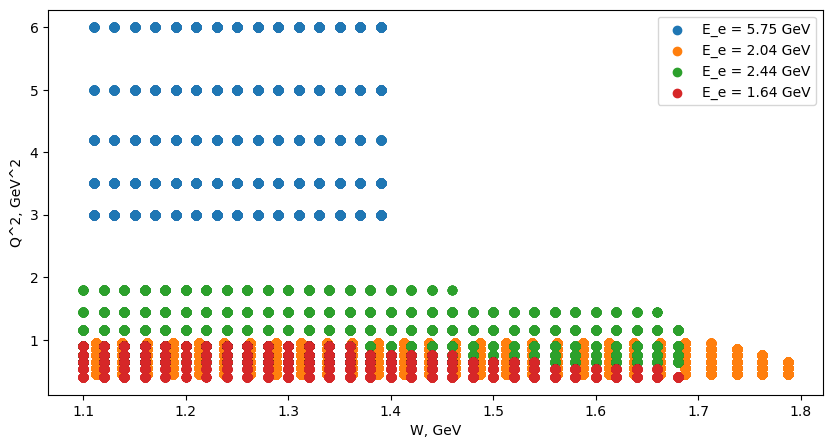

In [7]:
plt.rcParams["figure.figsize"] = (10,5)
plt.scatter(df[df.Ebeam==5.75].W, df[df.Ebeam==5.75].Q2, label='E_e = 5.75 GeV')
plt.scatter(df[df.Ebeam==2.04].W, df[df.Ebeam==2.04].Q2, label='E_e = 2.04 GeV')
plt.scatter(df[df.Ebeam==2.44].W, df[df.Ebeam==2.44].Q2, label='E_e = 2.44 GeV')
plt.scatter(df[df.Ebeam==1.64].W, df[df.Ebeam==1.64].Q2, label='E_e = 1.64 GeV')
plt.legend()
plt.xlabel('W, GeV')
plt.ylabel('Q^2, GeV^2')

#TRAINING

In [8]:
# Initialize wandb
wandb.init(entity='nucl_clas', project="FCNN for ep->ep_pi0, unified topology", name="7.6 Loss Function: Root Mean Squared Logarithmic Error")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: chistiakova-vv19 (nucl_clas) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [9]:
class RMSLELoss(torch.nn.Module):
    def __init__(self):
        super(RMSLELoss,self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, preds, target):
        criterion = torch.sqrt(self.mse(torch.log(preds + 1), torch.log(target + 1)))
        return criterion

#params
project_name = "FCNN for ep->ep_pi0, unified topology"

logger_path = './wandb_local_logs'
data_path = '/content/clasdb_pi_0_p.txt'

hyperparams_dict = {
    'feature_engineering': False,
    'scale_data': True,
    'feature_scaler': StandardScaler(),
    'label_scaler': MinMaxScaler(),
    'augment': False,
    'augment_factor': 5,
    'test_size': 0.1,
    'batch_size': 256,
    'net_architecture': [6,60,80,100,120,140,240,340,440,640,2000,1040,640,340,
                         240,140,100,80,60,20,1],  #the 1st layer is 6 or 37
    'activation_function': nn.ReLU(), #nn.LeakyReLU(0.01),
    'loss_func': RMSLELoss(),
    'optim_func': torch.optim.Adam,
    'max_epochs': 200,
    'es_min_delta': 1e-05,
    'es_patience': 30,
    'lr': 0.001,
    'lr_factor': 0.5,
    'lr_patience': 5,
    'lr_cooldown': 20,
}

wandb_logger = WandbLogger(project=project_name,
                           save_dir=logger_path)
exp_name = wandb_logger.experiment.name

logger_full_path = os.path.join(logger_path, project_name, exp_name)

os.makedirs(logger_full_path, exist_ok=True)
logging.basicConfig(encoding='utf-8',
                    level=logging.DEBUG,
                    format='%(asctime)s : %(levelname)s : %(message)s',
                    handlers=[logging.FileHandler(os.path.join(logger_full_path, 'logs.log'), mode='w'),
                              logging.StreamHandler(sys.stdout)],
                    force=True)

class InterpolDataSet(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        self.len = len(labels)

    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        return feature, label

    def __len__(self):
        return self.len

class InterpolDataModule(pl.LightningDataModule):
    def __init__(self, hyperparams):
        super().__init__()
        self.df = None
        self.hyperparams = hyperparams
        self.train_dataset = None
        self.val_dataset = None

    def augment(self, new_augm):
        augm_phi = np.clip(np.random.normal(loc=new_augm.phi, scale=new_augm.phi/30), 0, 2*np.pi)
        augm = pd.Series({'Ebeam': np.random.normal(loc=new_augm.Ebeam, scale=new_augm.Ebeam/30),
                           'W': np.random.normal(loc=new_augm.W, scale=new_augm.W/30),
                           'Q2': np.random.normal(loc=new_augm.Q2, scale=new_augm.Q2/30),
                           'cos_theta': np.clip(np.random.normal(loc=new_augm.cos_theta, scale=abs(new_augm.cos_theta/30)), -1, 1),
                           'phi': augm_phi,
                           'cos_phi': math.cos(augm_phi),
                           'sin_phi': math.sin(augm_phi),
                           'dsigma_dOmega': np.random.normal(loc=new_augm.dsigma_dOmega, scale=new_augm.error/3),
                           'error': new_augm.error,
                           #'reaction_type': new_augm.reaction_type,
                          })
        return augm

    def feature_engineering(self, df):
        df_feature = df[['Ebeam', 'W', 'Q2', 'cos_theta', 'cos_phi','sin_phi']]
        es = ft.EntitySet(id="data")
        es = es.add_dataframe(dataframe_name="data", dataframe=df_feature, make_index = True, index='index')

        # Run deep feature synthesis with transformation primitives
        feature_matrix, feature_defs = ft.dfs(entityset = es, target_dataframe_name = 'data',
                                              trans_primitives = ['add_numeric', 'multiply_numeric'])

        df_after_feature_eng = feature_matrix.copy()
        #df_after_feature_eng['reaction_type'] = df['reaction_type']
        return df_after_feature_eng


    #DATA READING AND PREPROCESSING
    def setup(self, stage):
        # df for ep->ep_pi0, reaction_type=1
        # Ebeam = [1.64 2.44 5.75 2.04]
        df_p = pd.read_csv('/content/clasdb_pi_0_p.txt', delimiter='\t', header=None)
        df_p.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
        df_p['phi'] = df_p.phi.apply(lambda x: math.radians(x))
        df_p['cos_phi'] = df_p['phi'].apply(lambda x: math.cos(x))
        df_p['sin_phi'] = df_p['phi'].apply(lambda x: math.sin(x))
        df_p['Ebeam'] = df_p['Ebeam'].round(decimals=2)                              #PREPROCESSING
        df_p = df_p.replace({"Ebeam": {2.45: 2.44, 1.65: 1.64}})                     #PREPROCESSING
        #df_p = df_p[df_p['dsigma_dOmega'] <= df_p["dsigma_dOmega"].quantile(0.97)]   #PREPROCESSING
        #df_p = df_p[df_p['error'] <= df_p["error"].quantile(0.98)]                   #PREPROCESSING
        df_p = df_p.drop(df_p[df_p['dsigma_dOmega'] == 0].index)                     #PREPROCESSING
        #df_p["reaction_type"] = 1
        df_p = df_p.drop('id', axis=1)
        df_p = df_p.reset_index(drop=True)
        df_p = df_p.iloc[df_p[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
        df_p = df_p.reset_index(drop=True)
        df = df_p.copy()

        # # df for ep->en_pi+, reaction_type=0
        # df_n = pd.read_csv('/content/clasdb_pi_plus_n.txt', delimiter='\t', header=None)
        # df_n.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
        # df_n.loc[8314:65670, 'Ebeam'] = 5.754 # peculiarity of this dataset.
        # df_n['phi'] = df_n.phi.apply(lambda x: math.radians(x))
        # df_n['cos_phi'] = df_n['phi'].apply(lambda x: math.cos(x))
        # df_n['sin_phi'] = df_n['phi'].apply(lambda x: math.sin(x))
        # df_n = df_n[df_n['dsigma_dOmega'] <= df_n["dsigma_dOmega"].quantile(0.97)]
        # df_n = df_n[df_n['error'] <= df_n["error"].quantile(0.98)]
        # df_n = df_n.drop('id', axis=1)
        # df_n = df_n.reset_index(drop=True)
        # df_n = df_n.iloc[df_n[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
        # df_n["reaction_type"] = 0
        # df_n = df_n.reset_index(drop=True)

        # # concat df_p and df_n into df
        # df = pd.concat([df_p, df_n], ignore_index=True)
        self.df = df

        feature_columns = list(df.columns)
        feature_columns.remove('dsigma_dOmega')
        feature_data = df[feature_columns]
        label_data = df['dsigma_dOmega']


        #TRAIN TEST SPLIT
        train_feature_data, val_feature_data, train_label_data, val_label_data = train_test_split(feature_data,
                                                                                                  label_data,
                                                                                                  test_size=self.hyperparams.get('test_size'),
                                                                                                  random_state=42)


        # AUGMENTATION ON TRAIN DATA
        if self.hyperparams.get('augment'):
            train_df = pd.concat([train_feature_data, train_label_data], axis=1)
            aug_series_list = []
            for i in tqdm.tqdm(train_df.itertuples()):
                for _ in range(self.hyperparams.get('augment_factor')):
                    aug_series_list.append(self.augment(i))

            aug_df = pd.DataFrame(aug_series_list)
            augment_train_df = pd.concat([train_df, aug_df], ignore_index=True)
            train_label_data = augment_train_df["dsigma_dOmega"]
            train_feature_data = augment_train_df.loc[:, ~augment_train_df.columns.isin(["dsigma_dOmega"])]
        else:
            pass

        # DELETING PHI AND ERROR FROM FEATURES
        train_feature_data = train_feature_data.reset_index(drop=True)
        val_feature_data = val_feature_data.reset_index(drop=True)
        train_feature_data = train_feature_data.loc[:, ~train_feature_data.columns.isin(["phi", "error"])]
        val_feature_data = val_feature_data.loc[:, ~val_feature_data.columns.isin(["phi", "error"])]


        # FEATURE ENGINEERING
        if self.hyperparams.get('feature_engineering'):
            train_feature_data = self.feature_engineering(train_feature_data)
            val_feature_data = self.feature_engineering(val_feature_data)
        else:
            pass


        # SCALE DATA (FIT_TRANSFORM TRAIN AND TRANSFORM VAL)
        # DON'T SCALE REACTION_TYPE IN FEATURE DATASETS
        if self.hyperparams.get('scale_data'):
            #scale feature_data
            scaler_feature = self.hyperparams.get('feature_scaler')
            train_feature_data = train_feature_data.reset_index(drop=True)
            val_feature_data = val_feature_data.reset_index(drop=True)

            columns_to_scale = list(train_feature_data.columns)
            #columns_to_scale.remove("reaction_type")
            train_feature_data[columns_to_scale] = pd.DataFrame(scaler_feature.fit_transform(train_feature_data[columns_to_scale]))
            val_feature_data[columns_to_scale] = pd.DataFrame(scaler_feature.transform(val_feature_data[columns_to_scale]))

            #scale label_data
            scaler_target = self.hyperparams.get('label_scaler')
            train_label_data = pd.Series(scaler_target.fit_transform(train_label_data.to_frame())[:,0])
            val_label_data = pd.Series(scaler_target.transform(val_label_data.to_frame())[:,0])
        else:
            pass


        self.train_dataset = InterpolDataSet(torch.tensor(train_feature_data.values, dtype=torch.float32),
                                             torch.tensor(train_label_data.values, dtype=torch.float32))

        self.val_dataset = InterpolDataSet(torch.tensor(val_feature_data.values, dtype=torch.float32),
                                           torch.tensor(val_label_data.values, dtype=torch.float32))


    def train_dataloader(self):
        return DataLoader(dataset = self.train_dataset, batch_size = self.hyperparams.get('batch_size'), shuffle = True, num_workers=0)

    def val_dataloader(self):
        return DataLoader(dataset = self.val_dataset, batch_size = self.hyperparams.get('batch_size'), shuffle = False, num_workers=0)



class PrintCallbacks(Callback):
    def on_train_start(self, trainer, pl_module):
        logging.info("Training is starting")

    def on_train_end(self, trainer, pl_module):
        logging.info("Training is ending")

    def on_train_epoch_end(self, trainer, pl_module):
        epoch_mean = torch.stack(pl_module.training_step_outputs).mean()
        logging.info(f"epoch: {pl_module.current_epoch}; train_loss: {epoch_mean}")
        pl_module.training_step_outputs.clear()

    def on_validation_epoch_end(self, trainer, pl_module):
        epoch_mean = torch.stack(pl_module.validation_step_outputs).mean()
        logging.info(f"epoch: {pl_module.current_epoch}; val_loss: {epoch_mean}")
        pl_module.validation_step_outputs.clear()

class InterpolRegressor(pl.LightningModule):
    def __init__(self, hyperparams):
        super(InterpolRegressor, self).__init__()

        self.train_loss, self.train_mae, self.val_loss, self.val_mae = 0,0,0,0
        self.train_mse, self.val_mse = 0,0
        self.train_rmse, self.val_rmse = 0,0
        self.train_r2, self.val_r2 = 0,0
        self.hyperparams = hyperparams
        self.save_hyperparameters(self.hyperparams)

        self.mae = MeanAbsoluteError()
        self.mse = MeanSquaredError()
        self.rmse = self.mse ** 0.5
        self.r2 = R2Score()
        self.loss_func = self.hyperparams.get('loss_func')

        self.optim = self.hyperparams.get('optim_func')

        self.net_architecture = self.hyperparams.get('net_architecture')
        self.activation_function = self.hyperparams.get('activation_function')

        self.training_step_outputs = []
        self.validation_step_outputs = []

        self.net = nn.Sequential()
        for i in range(1,len(self.net_architecture)):
            self.net.append(nn.Linear(self.net_architecture[i-1], self.net_architecture[i]))
            if i!=len(self.net_architecture)-1:
                self.net.append(self.activation_function)
            else:
                pass

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        loss = self.loss_func
        self.train_loss = loss.forward(y_hat.reshape(-1), y)
        self.train_mae = self.mae(y_hat.reshape(-1), y)
        self.train_mse = self.mse(y_hat.reshape(-1), y)
        self.train_rmse = self.rmse(y_hat.reshape(-1), y)
        self.train_r2 = self.r2(y_hat.reshape(-1), y)

        self.log('train_loss', self.train_loss, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_mae', self.train_mae, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_mse', self.train_mse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_rmse', self.train_rmse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_r2', self.train_r2, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)

        self.training_step_outputs.append(self.train_loss)
        return self.train_loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        loss = self.loss_func
        self.val_loss = loss.forward(y_hat.reshape(-1), y)
        self.val_mae = self.mae(y_hat.reshape(-1), y)
        self.val_mse = self.mse(y_hat.reshape(-1), y)
        self.val_rmse = self.rmse(y_hat.reshape(-1), y)
        self.val_r2 = self.r2(y_hat.reshape(-1), y)

        self.log('val_loss', self.val_loss, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_mae', self.val_mae, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_mse', self.val_mse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_rmse', self.val_rmse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_r2', self.val_r2, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)

        self.validation_step_outputs.append(self.val_loss)
        return self.val_loss

    def on_validation_epoch_end(self):
        sch = self.lr_schedulers()
        if isinstance(sch, torch.optim.lr_scheduler.ReduceLROnPlateau) and self.trainer.current_epoch!=0:
                sch.step(self.trainer.callback_metrics["val_loss"])

    def configure_callbacks(self):
        early_stop_callback = EarlyStopping(monitor="val_loss", mode="min",
                                            min_delta=self.hyperparams.get('es_min_delta'),
                                            patience=self.hyperparams.get('es_patience'),
                                            verbose=True)

        checkpoint_callback = ModelCheckpoint(save_top_k=3,
                                              monitor="val_loss",
                                              mode="min",
                                              dirpath=f"{logger_full_path}/checkpoints",
                                              filename="{exp_name}{val_loss:.5f}-{epoch:02d}")

        lr_monitor = LearningRateMonitor(logging_interval='epoch')

        print_callback = PrintCallbacks()

        return [early_stop_callback, checkpoint_callback, print_callback, lr_monitor]

    def configure_optimizers(self):
        optimizer = self.optim(self.parameters(), lr=self.hyperparams.get('lr'))
        lr_optim = ReduceLROnPlateau(optimizer = optimizer,
                                     mode = 'min',
                                     factor = self.hyperparams.get('lr_factor'),
                                     patience = self.hyperparams.get('lr_patience'),
                                     cooldown=self.hyperparams.get('lr_cooldown'),
                                     threshold=0.01,
                                     verbose= True)
        return {"optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": lr_optim,
                    "interval": "epoch",
                    "monitor": "val_loss",
                    "frequency": 2,
                    "name": 'lr_scheduler_monitoring'}
                }

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


In [10]:
data_module = InterpolDataModule(hyperparams=hyperparams_dict)
model = InterpolRegressor(hyperparams=hyperparams_dict)

trainer = pl.Trainer(max_epochs=hyperparams_dict.get('max_epochs'),
                     num_sanity_val_steps=0,
                     accelerator=device,
                     logger=wandb_logger,
                     enable_progress_bar=False)
trainer.fit(model, data_module)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
INFO: GPU available: True (cuda), used: True


2025-02-08 07:01:08,137 : INFO : GPU available: True (cuda), used: True


INFO: TPU available: False, using: 0 TPU cores


2025-02-08 07:01:08,142 : INFO : TPU available: False, using: 0 TPU cores


INFO: HPU available: False, using: 0 HPUs


2025-02-08 07:01:08,145 : INFO : HPU available: False, using: 0 HPUs


INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint


2025-02-08 07:01:08,153 : INFO : The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


2025-02-08 07:01:09,229 : INFO : LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


INFO: 
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | mae                 | MeanAbsoluteError   | 0      | train
1 | mse                 | MeanSquaredError    | 0      | train
2 | rmse                | CompositionalMetric | 0      | train
3 | r2                  | R2Score             | 0      | train
4 | loss_func           | RMSLELoss           | 0      | train
5 | activation_function | ReLU                | 0      | train
6 | net                 | Sequential          | 5.0 M  | train
--------------------------------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.926    Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


2025-02-08 07:01:09,497 : INFO : 
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | mae                 | MeanAbsoluteError   | 0      | train
1 | mse                 | MeanSquaredError    | 0      | train
2 | rmse                | CompositionalMetric | 0      | train
3 | r2                  | R2Score             | 0      | train
4 | loss_func           | RMSLELoss           | 0      | train
5 | activation_function | ReLU                | 0      | train
6 | net                 | Sequential          | 5.0 M  | train
--------------------------------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.926    Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode
2025-02-08 07:01:09,623 : INFO : Training is starting
2025-02-08 07:01:15,037 : INFO : epoch: 0; val_loss: 0.06422372907400131
2025

INFO: Metric val_loss improved. New best score: 0.064


2025-02-08 07:01:15,069 : INFO : Metric val_loss improved. New best score: 0.064
2025-02-08 07:01:15,216 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarithmic Error/checkpoints/exp_name=0val_loss=0.06422-epoch=00.ckpt
2025-02-08 07:01:19,284 : INFO : epoch: 1; val_loss: 0.0643775686621666
2025-02-08 07:01:19,290 : INFO : epoch: 1; train_loss: 0.06201954558491707
2025-02-08 07:01:19,393 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarithmic Error/checkpoints/exp_name=0val_loss=0.06438-epoch=01.ckpt
2025-02-08 07:01:23,033 : INFO : epoch: 2; val_loss: 0.0479360930621624
2025-02-08 07:01:23,039 : INFO : epoch: 2; train_loss: 0.05548308417201042


INFO: Metric val_loss improved by 0.016 >= min_delta = 1e-05. New best score: 0.048


2025-02-08 07:01:23,055 : INFO : Metric val_loss improved by 0.016 >= min_delta = 1e-05. New best score: 0.048
2025-02-08 07:01:23,150 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarithmic Error/checkpoints/exp_name=0val_loss=0.04794-epoch=02.ckpt
2025-02-08 07:01:26,926 : INFO : epoch: 3; val_loss: 0.03263230621814728
2025-02-08 07:01:26,931 : INFO : epoch: 3; train_loss: 0.03857136145234108


INFO: Metric val_loss improved by 0.015 >= min_delta = 1e-05. New best score: 0.033


2025-02-08 07:01:26,946 : INFO : Metric val_loss improved by 0.015 >= min_delta = 1e-05. New best score: 0.033
2025-02-08 07:01:27,085 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarithmic Error/checkpoints/exp_name=0val_loss=0.03263-epoch=03.ckpt
2025-02-08 07:01:31,649 : INFO : epoch: 4; val_loss: 0.02631266973912716
2025-02-08 07:01:31,654 : INFO : epoch: 4; train_loss: 0.027477048337459564


INFO: Metric val_loss improved by 0.006 >= min_delta = 1e-05. New best score: 0.026


2025-02-08 07:01:31,664 : INFO : Metric val_loss improved by 0.006 >= min_delta = 1e-05. New best score: 0.026
2025-02-08 07:01:31,767 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarithmic Error/checkpoints/exp_name=0val_loss=0.02631-epoch=04.ckpt
2025-02-08 07:01:35,403 : INFO : epoch: 5; val_loss: 0.03225429728627205
2025-02-08 07:01:35,409 : INFO : epoch: 5; train_loss: 0.02422051690518856
2025-02-08 07:01:35,515 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarithmic Error/checkpoints/exp_name=0val_loss=0.03225-epoch=05.ckpt
2025-02-08 07:01:39,166 : INFO : epoch: 6; val_loss: 0.03691248223185539
2025-02-08 07:01:39,171 : INFO : epoch: 6; train_loss: 0.024158108979463577
2025-02-08 07:01:43,554 : INFO : epoch: 7; val_loss: 0.0322466678917408
2025-02-08 07:01:43,558 : INFO : epoch: 7; train_loss: 0.024203171953558922
2025-02-08

INFO: Metric val_loss improved by 0.005 >= min_delta = 1e-05. New best score: 0.022


2025-02-08 07:01:47,333 : INFO : Metric val_loss improved by 0.005 >= min_delta = 1e-05. New best score: 0.022
2025-02-08 07:01:47,445 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarithmic Error/checkpoints/exp_name=0val_loss=0.02163-epoch=08.ckpt
2025-02-08 07:01:51,313 : INFO : epoch: 9; val_loss: 0.022296227514743805
2025-02-08 07:01:51,319 : INFO : epoch: 9; train_loss: 0.021068476140499115
2025-02-08 07:01:51,427 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarithmic Error/checkpoints/exp_name=0val_loss=0.02230-epoch=09.ckpt
2025-02-08 07:01:56,175 : INFO : epoch: 10; val_loss: 0.02409859374165535
2025-02-08 07:01:56,180 : INFO : epoch: 10; train_loss: 0.020893333479762077
2025-02-08 07:01:56,327 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarith

INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.021


2025-02-08 07:02:01,342 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.021
2025-02-08 07:02:01,637 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarithmic Error/checkpoints/exp_name=0val_loss=0.02072-epoch=11.ckpt
2025-02-08 07:02:05,613 : INFO : epoch: 12; val_loss: 0.02078276127576828
2025-02-08 07:02:05,623 : INFO : epoch: 12; train_loss: 0.019959628582000732
2025-02-08 07:02:05,772 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarithmic Error/checkpoints/exp_name=0val_loss=0.02078-epoch=12.ckpt
2025-02-08 07:02:09,992 : INFO : epoch: 13; val_loss: 0.02039700374007225
2025-02-08 07:02:09,998 : INFO : epoch: 13; train_loss: 0.019702767953276634


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.020


2025-02-08 07:02:10,009 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.020
2025-02-08 07:02:10,107 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarithmic Error/checkpoints/exp_name=0val_loss=0.02040-epoch=13.ckpt
2025-02-08 07:02:14,005 : INFO : epoch: 14; val_loss: 0.02662055939435959
2025-02-08 07:02:14,010 : INFO : epoch: 14; train_loss: 0.019539885222911835
2025-02-08 07:02:17,735 : INFO : epoch: 15; val_loss: 0.021954812109470367
2025-02-08 07:02:17,743 : INFO : epoch: 15; train_loss: 0.02042100392282009
2025-02-08 07:02:21,972 : INFO : epoch: 16; val_loss: 0.02236812189221382
2025-02-08 07:02:21,978 : INFO : epoch: 16; train_loss: 0.019669033586978912
2025-02-08 07:02:25,494 : INFO : epoch: 17; val_loss: 0.019838398322463036
2025-02-08 07:02:25,499 : INFO : epoch: 17; train_loss: 0.019748590886592865


INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.020


2025-02-08 07:02:25,511 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.020
2025-02-08 07:02:25,617 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarithmic Error/checkpoints/exp_name=0val_loss=0.01984-epoch=17.ckpt
2025-02-08 07:02:29,323 : INFO : epoch: 18; val_loss: 0.020184025168418884
2025-02-08 07:02:29,329 : INFO : epoch: 18; train_loss: 0.018994471058249474
2025-02-08 07:02:29,437 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarithmic Error/checkpoints/exp_name=0val_loss=0.02018-epoch=18.ckpt
2025-02-08 07:02:34,185 : INFO : epoch: 19; val_loss: 0.02373415045440197
2025-02-08 07:02:34,190 : INFO : epoch: 19; train_loss: 0.019033679738640785
2025-02-08 07:02:37,739 : INFO : epoch: 20; val_loss: 0.020647713914513588
2025-02-08 07:02:37,745 : INFO : epoch: 20; train_loss: 0.019397946074604988


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.019


2025-02-08 07:02:49,496 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.019
2025-02-08 07:02:49,590 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarithmic Error/checkpoints/exp_name=0val_loss=0.01946-epoch=23.ckpt
2025-02-08 07:02:53,529 : INFO : epoch: 24; val_loss: 0.019485516473650932
2025-02-08 07:02:53,535 : INFO : epoch: 24; train_loss: 0.018127722665667534
2025-02-08 07:02:53,644 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarithmic Error/checkpoints/exp_name=0val_loss=0.01949-epoch=24.ckpt
2025-02-08 07:02:58,203 : INFO : epoch: 25; val_loss: 0.019653715193271637
2025-02-08 07:02:58,208 : INFO : epoch: 25; train_loss: 0.018135560676455498
2025-02-08 07:02:58,319 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logar

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.019


2025-02-08 07:03:05,627 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.019
2025-02-08 07:03:05,724 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarithmic Error/checkpoints/exp_name=0val_loss=0.01929-epoch=27.ckpt
2025-02-08 07:03:09,998 : INFO : epoch: 28; val_loss: 0.020001385360956192
2025-02-08 07:03:10,003 : INFO : epoch: 28; train_loss: 0.018087897449731827
2025-02-08 07:03:14,139 : INFO : epoch: 29; val_loss: 0.019080961123108864
2025-02-08 07:03:14,144 : INFO : epoch: 29; train_loss: 0.01823723502457142


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.019


2025-02-08 07:03:14,158 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.019
2025-02-08 07:03:14,255 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarithmic Error/checkpoints/exp_name=0val_loss=0.01908-epoch=29.ckpt
2025-02-08 07:03:17,891 : INFO : epoch: 30; val_loss: 0.02058529108762741
2025-02-08 07:03:17,896 : INFO : epoch: 30; train_loss: 0.018276596441864967
2025-02-08 07:03:21,754 : INFO : epoch: 31; val_loss: 0.020157644525170326
2025-02-08 07:03:21,759 : INFO : epoch: 31; train_loss: 0.01815780997276306
2025-02-08 07:03:25,933 : INFO : epoch: 32; val_loss: 0.019641581922769547
2025-02-08 07:03:25,938 : INFO : epoch: 32; train_loss: 0.01796095259487629
2025-02-08 07:03:29,745 : INFO : epoch: 33; val_loss: 0.019789230078458786
2025-02-08 07:03:29,751 : INFO : epoch: 33; train_loss: 0.01796533167362213
2025-02-08 07:03:33,287 : INFO : epoch: 34; val_loss: 0.022889519110

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.019


2025-02-08 07:03:53,181 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.019
2025-02-08 07:03:53,288 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarithmic Error/checkpoints/exp_name=0val_loss=0.01898-epoch=39.ckpt
2025-02-08 07:03:57,265 : INFO : epoch: 40; val_loss: 0.019128788262605667
2025-02-08 07:03:57,270 : INFO : epoch: 40; train_loss: 0.017527738586068153
2025-02-08 07:03:57,377 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarithmic Error/checkpoints/exp_name=0val_loss=0.01913-epoch=40.ckpt
2025-02-08 07:04:02,031 : INFO : epoch: 41; val_loss: 0.018886258825659752
2025-02-08 07:04:02,036 : INFO : epoch: 41; train_loss: 0.017537694424390793


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.019


2025-02-08 07:04:02,047 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.019
2025-02-08 07:04:02,151 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarithmic Error/checkpoints/exp_name=0val_loss=0.01889-epoch=41.ckpt
2025-02-08 07:04:05,844 : INFO : epoch: 42; val_loss: 0.018817340955138206
2025-02-08 07:04:05,849 : INFO : epoch: 42; train_loss: 0.01750004105269909


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.019


2025-02-08 07:04:05,863 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.019
2025-02-08 07:04:05,958 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarithmic Error/checkpoints/exp_name=0val_loss=0.01882-epoch=42.ckpt
2025-02-08 07:04:09,914 : INFO : epoch: 43; val_loss: 0.018887905403971672
2025-02-08 07:04:09,921 : INFO : epoch: 43; train_loss: 0.017431290820240974
2025-02-08 07:04:10,027 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarithmic Error/checkpoints/exp_name=0val_loss=0.01889-epoch=43.ckpt
2025-02-08 07:04:14,629 : INFO : epoch: 44; val_loss: 0.01911790482699871
2025-02-08 07:04:14,635 : INFO : epoch: 44; train_loss: 0.017398077994585037
2025-02-08 07:04:18,172 : INFO : epoch: 45; val_loss: 0.019005604088306427
2025-02-08 07:04:18,177 : INFO : epoch: 45; train_loss: 0.017545420676469803


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.019


2025-02-08 07:04:21,749 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.019
2025-02-08 07:04:21,843 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarithmic Error/checkpoints/exp_name=0val_loss=0.01877-epoch=46.ckpt
2025-02-08 07:04:25,834 : INFO : epoch: 47; val_loss: 0.018972083926200867
2025-02-08 07:04:25,839 : INFO : epoch: 47; train_loss: 0.01739761047065258
2025-02-08 07:04:30,123 : INFO : epoch: 48; val_loss: 0.01885942369699478
2025-02-08 07:04:30,129 : INFO : epoch: 48; train_loss: 0.017413703724741936
2025-02-08 07:04:30,242 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarithmic Error/checkpoints/exp_name=0val_loss=0.01886-epoch=48.ckpt
2025-02-08 07:04:33,941 : INFO : epoch: 49; val_loss: 0.019130993634462357
2025-02-08 07:04:33,946 : INFO : epoch: 49; train_loss: 0.01753830723464489
20

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.019


2025-02-08 07:04:37,808 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.019
2025-02-08 07:04:37,938 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarithmic Error/checkpoints/exp_name=0val_loss=0.01876-epoch=50.ckpt
2025-02-08 07:04:42,206 : INFO : epoch: 51; val_loss: 0.018810171633958817
2025-02-08 07:04:42,212 : INFO : epoch: 51; train_loss: 0.017400851473212242
2025-02-08 07:04:42,325 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarithmic Error/checkpoints/exp_name=0val_loss=0.01881-epoch=51.ckpt
2025-02-08 07:04:46,066 : INFO : epoch: 52; val_loss: 0.018807237967848778
2025-02-08 07:04:46,071 : INFO : epoch: 52; train_loss: 0.017363736405968666
2025-02-08 07:04:46,178 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logar

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.019


2025-02-08 07:04:50,334 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.019
2025-02-08 07:04:50,466 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarithmic Error/checkpoints/exp_name=0val_loss=0.01874-epoch=53.ckpt
2025-02-08 07:04:55,762 : INFO : epoch: 54; val_loss: 0.02013799175620079
2025-02-08 07:04:55,767 : INFO : epoch: 54; train_loss: 0.01737282983958721
2025-02-08 07:04:59,334 : INFO : epoch: 55; val_loss: 0.01928635686635971
2025-02-08 07:04:59,340 : INFO : epoch: 55; train_loss: 0.0173867866396904
2025-02-08 07:05:03,101 : INFO : epoch: 56; val_loss: 0.018801337108016014
2025-02-08 07:05:03,106 : INFO : epoch: 56; train_loss: 0.01718100905418396
2025-02-08 07:05:07,317 : INFO : epoch: 57; val_loss: 0.018747156485915184
2025-02-08 07:05:07,322 : INFO : epoch: 57; train_loss: 0.017179517075419426
2025-02-08 07:05:07,450 : DEBUG : open file: /content/wandb_local_logs

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.019


2025-02-08 07:05:19,365 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.019
2025-02-08 07:05:19,466 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarithmic Error/checkpoints/exp_name=0val_loss=0.01873-epoch=60.ckpt
2025-02-08 07:05:23,101 : INFO : epoch: 61; val_loss: 0.01883275993168354
2025-02-08 07:05:23,107 : INFO : epoch: 61; train_loss: 0.017093475908041
2025-02-08 07:05:26,642 : INFO : epoch: 62; val_loss: 0.01883671246469021
2025-02-08 07:05:26,647 : INFO : epoch: 62; train_loss: 0.01710178330540657
2025-02-08 07:05:31,227 : INFO : epoch: 63; val_loss: 0.018743185326457024
2025-02-08 07:05:31,233 : INFO : epoch: 63; train_loss: 0.01714629866182804
2025-02-08 07:05:31,338 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarithmic Error/checkpoints/exp_name=0val_loss=0.01874-epoch=63.ckpt
2025-0

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.019


2025-02-08 07:05:34,979 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.019
2025-02-08 07:05:35,079 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarithmic Error/checkpoints/exp_name=0val_loss=0.01866-epoch=64.ckpt
2025-02-08 07:05:38,765 : INFO : epoch: 65; val_loss: 0.018707431852817535
2025-02-08 07:05:38,769 : INFO : epoch: 65; train_loss: 0.017081284895539284
2025-02-08 07:05:38,871 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarithmic Error/checkpoints/exp_name=0val_loss=0.01871-epoch=65.ckpt
2025-02-08 07:05:43,349 : INFO : epoch: 66; val_loss: 0.018635079264640808
2025-02-08 07:05:43,356 : INFO : epoch: 66; train_loss: 0.017131401225924492


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.019


2025-02-08 07:05:43,373 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.019
2025-02-08 07:05:43,525 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarithmic Error/checkpoints/exp_name=0val_loss=0.01864-epoch=66.ckpt
2025-02-08 07:05:47,213 : INFO : epoch: 67; val_loss: 0.018658379092812538
2025-02-08 07:05:47,218 : INFO : epoch: 67; train_loss: 0.017059573903679848
2025-02-08 07:05:47,324 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarithmic Error/checkpoints/exp_name=0val_loss=0.01866-epoch=67.ckpt
2025-02-08 07:05:51,241 : INFO : epoch: 68; val_loss: 0.018768809735774994
2025-02-08 07:05:51,246 : INFO : epoch: 68; train_loss: 0.017092933878302574
2025-02-08 07:05:55,323 : INFO : epoch: 69; val_loss: 0.018902776762843132
2025-02-08 07:05:55,329 : INFO : epoch: 69; train_loss: 0.01705501414835453


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.019


2025-02-08 07:06:18,343 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.019
2025-02-08 07:06:18,444 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarithmic Error/checkpoints/exp_name=0val_loss=0.01861-epoch=75.ckpt
2025-02-08 07:06:23,028 : INFO : epoch: 76; val_loss: 0.01862623356282711
2025-02-08 07:06:23,033 : INFO : epoch: 76; train_loss: 0.016896922141313553
2025-02-08 07:06:23,144 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarithmic Error/checkpoints/exp_name=0val_loss=0.01863-epoch=76.ckpt
2025-02-08 07:06:26,858 : INFO : epoch: 77; val_loss: 0.01863916590809822
2025-02-08 07:06:26,862 : INFO : epoch: 77; train_loss: 0.01688932441174984
2025-02-08 07:06:30,776 : INFO : epoch: 78; val_loss: 0.018720941618084908
2025-02-08 07:06:30,781 : INFO : epoch: 78; train_loss: 0.016943760216236115
20

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.019


2025-02-08 07:07:45,710 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.019
2025-02-08 07:07:45,815 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarithmic Error/checkpoints/exp_name=0val_loss=0.01859-epoch=97.ckpt
2025-02-08 07:07:50,667 : INFO : epoch: 98; val_loss: 0.018607966601848602
2025-02-08 07:07:50,672 : INFO : epoch: 98; train_loss: 0.016790173947811127
2025-02-08 07:07:55,146 : INFO : epoch: 99; val_loss: 0.018603580072522163
2025-02-08 07:07:55,152 : INFO : epoch: 99; train_loss: 0.016780177131295204
2025-02-08 07:07:55,258 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarithmic Error/checkpoints/exp_name=0val_loss=0.01860-epoch=99.ckpt
2025-02-08 07:07:58,933 : INFO : epoch: 100; val_loss: 0.018611567094922066
2025-02-08 07:07:58,938 : INFO : epoch: 100; train_loss: 0.0168414842337369

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.019


2025-02-08 07:08:31,483 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.019
2025-02-08 07:08:31,582 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarithmic Error/checkpoints/exp_name=0val_loss=0.01857-epoch=108.ckpt
2025-02-08 07:08:35,343 : INFO : epoch: 109; val_loss: 0.018594946712255478
2025-02-08 07:08:35,348 : INFO : epoch: 109; train_loss: 0.016682682558894157
2025-02-08 07:08:39,259 : INFO : epoch: 110; val_loss: 0.018567290157079697
2025-02-08 07:08:39,268 : INFO : epoch: 110; train_loss: 0.016770469024777412
2025-02-08 07:08:39,428 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarithmic Error/checkpoints/exp_name=0val_loss=0.01857-epoch=110.ckpt
2025-02-08 07:08:43,806 : INFO : epoch: 111; val_loss: 0.018568770959973335
2025-02-08 07:08:43,812 : INFO : epoch: 111; train_loss: 0.0167387817

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.019


2025-02-08 07:10:11,694 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.019
2025-02-08 07:10:11,797 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/7.6 Loss Function: Root Mean Squared Logarithmic Error/checkpoints/exp_name=0val_loss=0.01856-epoch=133.ckpt
2025-02-08 07:10:15,554 : INFO : epoch: 134; val_loss: 0.018562667071819305
2025-02-08 07:10:15,559 : INFO : epoch: 134; train_loss: 0.01676308363676071
2025-02-08 07:10:19,187 : INFO : epoch: 135; val_loss: 0.018565107136964798
2025-02-08 07:10:19,192 : INFO : epoch: 135; train_loss: 0.0166902095079422
2025-02-08 07:10:23,611 : INFO : epoch: 136; val_loss: 0.018565695732831955
2025-02-08 07:10:23,617 : INFO : epoch: 136; train_loss: 0.01667795516550541
2025-02-08 07:10:27,214 : INFO : epoch: 137; val_loss: 0.018567606806755066
2025-02-08 07:10:27,220 : INFO : epoch: 137; train_loss: 0.016739897429943085
2025-02-08 07:10:31,053 : INFO : epoch: 138; val_loss: 0.01

INFO: Monitored metric val_loss did not improve in the last 30 records. Best score: 0.019. Signaling Trainer to stop.


2025-02-08 07:12:11,240 : INFO : Monitored metric val_loss did not improve in the last 30 records. Best score: 0.019. Signaling Trainer to stop.
2025-02-08 07:12:11,246 : INFO : Training is ending


# PLOT CROSS SECTIONS & STRUCTURE FUNCTIONS

In [11]:
model.eval()

# generate grid
def generate_grid_df(Ebeam):
    step_W = 0.005
    step_Q2 = 0.1
    step_cos_theta = 0.1
    step_phi = 0.05

    W_min = df[df.Ebeam==Ebeam].W.min() - 0.1
    W_max = df[df.Ebeam==Ebeam].W.max() + 0.1 + step_W

    Q2_min = df[df.Ebeam==Ebeam].Q2.min() - 0.1
    Q2_max = df[df.Ebeam==Ebeam].Q2.max() + 0.1 + step_Q2

    data_grid = []
    for W in tqdm.tqdm(np.arange(W_min, W_max, step_W)):
        for Q2 in np.arange(Q2_min, Q2_max, step_Q2):
            for cos_theta in np.arange(-1, 1+step_cos_theta, step_cos_theta):
                for phi in np.arange(0, 2*np.pi, step_phi):
                    data_grid.append([Ebeam,W,Q2,cos_theta,phi])

    df_grid = pd.DataFrame(data_grid)
    df_grid.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']

    df_grid.W = np.round(df_grid.W, 3)
    df_grid.Q2 = np.round(df_grid.Q2, 3)
    df_grid.cos_theta = np.round(df_grid.cos_theta, 3)
    df_grid.phi = np.round(df_grid.phi, 3)
    df_grid['cos_phi'] = df_grid['phi'].apply(lambda x: math.cos(x))
    df_grid['sin_phi'] = df_grid['phi'].apply(lambda x: math.sin(x))

    # feature engineering
    if model.hyperparams.get('feature_engineering'):
        def feature_engineering(df):
                df_feature = df[['Ebeam', 'W', 'Q2', 'cos_theta', 'cos_phi','sin_phi']]
                es = ft.EntitySet(id="data")
                es = es.add_dataframe(dataframe_name="data", dataframe=df_feature, make_index = True, index='index')

                # Run deep feature synthesis with transformation primitives
                feature_matrix, feature_defs = ft.dfs(entityset = es, target_dataframe_name = 'data',
                                                      trans_primitives = ['add_numeric', 'multiply_numeric'])

                df_after_feature_eng = feature_matrix.copy()
                #df_after_feature_eng['reaction_type'] = df['reaction_type']
                return df_after_feature_eng

        df_grid_for_prediction = feature_engineering(df_grid)
    else:
        df_grid_for_prediction = df_grid.loc[:, ~df_grid.columns.isin(["phi", "error"])]

    #scale feature data
    if model.hyperparams.get('scale_data'):
        scaler_feature = model.hyperparams.get('feature_scaler')
        columns_to_scale = list(df_grid_for_prediction.columns)
        #columns_to_scale.remove("reaction_type")
        df_grid_for_prediction[columns_to_scale] = pd.DataFrame(scaler_feature.transform(df_grid_for_prediction[columns_to_scale]))
    else:
        pass

    # predict crosssections
    df_grid_parts = np.array_split(df_grid_for_prediction, 100)
    df_grid_parts_preds = []
    for df_grid_part in tqdm.tqdm(df_grid_parts):
        dsigma_dOmega_predicted = model.forward(torch.tensor(df_grid_part.to_numpy(),dtype=torch.float32)).detach()

        df_grid_part['dsigma_dOmega_predicted'] = dsigma_dOmega_predicted
        #df_grid_part.dsigma_dOmega_predicted = abs(df_grid_part.dsigma_dOmega_predicted)
        df_grid_parts_preds.append(df_grid_part)

    df_grid_for_prediction = pd.concat(df_grid_parts_preds)
    df_grid['dsigma_dOmega_predicted'] = df_grid_for_prediction["dsigma_dOmega_predicted"]
    del(df_grid_for_prediction)
    df_grid['A'] = 0
    df_grid['B'] = 0
    df_grid['C'] = 0

    if model.hyperparams.get('scale_data'):
        scaler_target = model.hyperparams.get('label_scaler')
        df_grid['dsigma_dOmega_predicted'] = pd.Series(scaler_target.inverse_transform(df_grid["dsigma_dOmega_predicted"].to_frame())[:,0])
    else:
        pass

    # calculate structure functions
    phi_min_index = df_grid[df_grid.phi == df_grid.phi.min()].index.to_numpy()
    phi_max_index = df_grid[df_grid.phi == df_grid.phi.max()].index.to_numpy()

    for i in tqdm.tqdm(range(len(phi_min_index))):
        cross_section_chunk = df_grid.iloc[phi_min_index[i]:phi_max_index[i]].dsigma_dOmega_predicted
        cos_phi = np.cos(df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)
        cos_2_phi = np.cos(2*df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)

        trapz_A = np.trapz(cross_section_chunk, dx=step_phi)
        trapz_B = np.trapz(cross_section_chunk*cos_2_phi, dx=step_phi)
        trapz_C = np.trapz(cross_section_chunk*cos_phi, dx=step_phi)

        A = trapz_A/(2*np.pi)
        B = trapz_B/(np.pi)
        C = trapz_C/(np.pi)

        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'C'] = C

    df_grid['dsigma_dOmega_sf'] = df_grid['A'] + df_grid['B']*np.cos(2*df_grid['phi']) + df_grid['C']*np.cos(df_grid['phi'])
    return df_grid

# drawing
def find_closest(df_for_search, W_for_search, Q2_for_search):
    global closest_index
    closest_index = df_for_search[['W', 'Q2']].drop_duplicates(). \
                    apply(lambda x: spatial.distance.euclidean([W_for_search, Q2_for_search], [x.W, x.Q2]), axis=1).idxmin()
    assert isinstance(closest_index, tuple([int, np.int64]))
    return (df_for_search.loc[closest_index, 'W'], df_for_search.loc[closest_index, 'Q2'])

def plot_joint_cross_sections(df, E_beam, W, Q2, cos_theta, df_grid):
    W_df, Q2_df = find_closest(df, W, Q2)
    W_df_grid, Q2_df_grid = find_closest(df_grid, W, Q2)

    df_instance_set = df[(df.Ebeam == E_beam)&
                         #(df.error < 1.5)&      # delete large errors of real data
                         (df.W == W_df)&
                         (df.Q2 == Q2_df)&
                         (df.cos_theta == cos_theta)].sort_values('phi')

    df_grid_instance_set = df_grid[(df_grid.Ebeam == E_beam)&
                                    (df_grid.W == W_df_grid)&
                                    (df_grid.Q2 == Q2_df_grid)&
                                    (np.round(df_grid.cos_theta, 1) == cos_theta)].sort_values('phi')

    if len(df_instance_set)==0:
        print(len(df_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_instance_set)==0')

    if len(df_grid_instance_set)==0:
        print(len(df_grid_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_grid_instance_set)==0')

    def func_cos(x, a, b, c):
        return a + b*np.cos(2*x) + c*np.cos(x)

    #input data
    xdata_real = df_instance_set.phi
    ydata_real = df_instance_set.dsigma_dOmega
    ydata_error_real = df_instance_set.error

    xdata_preds = df_grid_instance_set.phi
    ydata_preds = df_grid_instance_set.dsigma_dOmega_predicted

    xdata_preds_sf = xdata_preds
    ydata_preds_sf = df_grid_instance_set.dsigma_dOmega_sf

    #fitting the data
    popt, pcov = curve_fit(func_cos, xdata_real, ydata_real, sigma=ydata_error_real, absolute_sigma=True)
    a, b, c = popt[0], popt[1], popt[2]

    # recovered

    xdata_fitted = [i for i in np.arange(0, 2*np.pi, 0.01)]
    ydata_fitted = [func_cos(x, a, b, c) for x in xdata_fitted]

    df_fitted = pd.DataFrame({'phi_fitted': xdata_fitted,
                              'dsigma_dOmega_fitted': ydata_fitted})

    df_chi_2 = pd.merge_asof(df_instance_set, df_fitted, left_on='phi', right_on='phi_fitted')
    df_chi_2 = pd.merge_asof(df_chi_2, df_grid_instance_set, on='phi')
    df_chi_2 = df_chi_2[['phi', 'dsigma_dOmega', 'dsigma_dOmega_fitted', 'dsigma_dOmega_predicted', 'dsigma_dOmega_sf']]

    real = df_chi_2['dsigma_dOmega'].apply(lambda x: np.round(x, 6)).values
    fitted = df_chi_2['dsigma_dOmega_fitted'].apply(lambda x: np.round(x, 6)).values
    preds = df_chi_2['dsigma_dOmega_predicted'].apply(lambda x: np.round(x, 6)).values
    preds_sf = df_chi_2['dsigma_dOmega_sf'].apply(lambda x: np.round(x, 6)).values

    stat_fitted_chi, p_value_fitted_chi = np.round(chisquare(real, np.sum(real)/np.sum(fitted)*fitted), 3)
    stat_preds_chi, p_value_preds_chi = np.round(chisquare(real, np.sum(real)/np.sum(preds)*preds), 3)
    stat_preds_sf_chi, p_value_preds_sf_chi = np.round(chisquare(real, np.sum(real)/np.sum(preds_sf)*preds_sf), 3)

    plt.figure(figsize=(22, 6), dpi=80)

    plt.figtext(0.13, 0.83, f'Params (exp, preds). W({W_df},{W_df_grid}); Q2({Q2_df},{Q2_df_grid})')

    # real data
    plt.scatter(x=xdata_real,
                y=ydata_real,
                color='red', marker='*', label=f"Experimental data. Params: Ebeam: {E_beam}, W: {W}, Q2: {Q2}, cos_theta: {cos_theta}")
    plt.errorbar(x=xdata_real,
                 y=ydata_real,
                 yerr=ydata_error_real,
                 color='red',
                 fmt='o')

    plt.plot(xdata_fitted,
             ydata_fitted,
             color='blue',
             label=f'Fitted data'
             #label=f'Fitted data, chi^2 = {stat_fitted_chi}, p_value = {p_value_fitted_chi}'
             )

    plt.plot(xdata_preds,
             ydata_preds,
             color='green',
             label=f'Predicted data'
             #label=f'Predicted data, chi^2 = {stat_preds_chi}, p_value = {p_value_preds_chi}'
             )

    plt.plot(xdata_preds_sf,
             ydata_preds_sf,
             color='black',
             label=f'Predictions and recovered data'
             #label=f'Predictions and recovered data, chi^2 = {stat_preds_sf_chi}, p_value = {p_value_preds_sf_chi}'
             )

    plt.ylim(ymin=0)
    plt.xlim(xmin=0, xmax=2*np.pi)

    plt.xlabel("phi: rad", fontsize="20")
    plt.ylabel("dsigma_dOmega: microbarn/sterad", fontsize="20")

    plt.legend(loc ="upper right", fontsize="15")

    plt.savefig(f'/content/NN/E_beam={Ebeam}/E_beam={E_beam}_Q2={Q2}_W={W}_cos_theta={cos_theta}.png')
    plt.show()
    plt.close()
    return None

def func_cos(x, a, b, c):
        return a + b*np.cos(2*x) + c*np.cos(x)

def fit_to_func(x):
    try:
        popt, pcov = curve_fit(func_cos, x.phi, x.dsigma_dOmega, sigma=x.error, absolute_sigma=True)
        a, b, c = popt[0], popt[1], popt[2]

        a_error, b_error, c_error = np.sqrt(pcov[0][0]), np.sqrt(pcov[1][1]), np.sqrt(pcov[2][2])

        return a, b, c, a_error, b_error, c_error
    except Exception as e:
        return None, None, None, None, None, None

def generate_df_sf(Ebeam):
    df_sf = df.groupby(['Ebeam', 'W', 'Q2', 'cos_theta']).apply(lambda x: fit_to_func(x)).reset_index()

    df_sf['A'] = df_sf[0].apply(lambda x: x[0])
    df_sf['B'] = df_sf[0].apply(lambda x: x[1])
    df_sf['C'] = df_sf[0].apply(lambda x: x[2])

    df_sf['A_error'] = df_sf[0].apply(lambda x: x[3])
    df_sf['B_error'] = df_sf[0].apply(lambda x: x[4])
    df_sf['C_error'] = df_sf[0].apply(lambda x: x[5])

    df_sf.drop(0, axis=1, inplace=True)
    df_sf.dropna(inplace=True)
    df_sf = df_sf[(df_sf["A_error"] < 3) & (df_sf["B_error"] < 3) & (df_sf["C_error"] < 3)]
    return df_sf

def plot_joint_sf(df, E_beam, Q2, cos_theta, df_grid, func, func_error):

    W_df, Q2_df = find_closest(df, W, Q2)
    W_df_grid, Q2_df_grid = find_closest(df_grid, W, Q2)

    df_instance_set = df[(df.Ebeam == E_beam)&
                        (df.Q2 == Q2)&
                        (df.cos_theta == cos_theta)].sort_values('W')

    df_grid_instance_set = df_grid[(df_grid.Ebeam == E_beam)&
                                    (df_grid.Q2 == Q2_df_grid)&
                                    (np.round(df_grid.cos_theta, 1) == cos_theta)].sort_values('W')

    df_grid_instance_set = df_grid_instance_set[(df_grid_instance_set['W']>=df_instance_set.W.min() - 0.2)&
                                                (df_grid_instance_set['W']<=df_instance_set.W.max() + 0.2)]

    if len(df_instance_set)==0:
        print(E_beam, Q2, cos_theta)
        raise ValueError('len(df_instance_set)==0')

    if len(df_grid_instance_set)==0:
        print(E_beam, Q2, cos_theta)
        raise ValueError('len(df_grid_instance_set)==0')

    xdata_real = df_instance_set.W
    ydata_real = df_instance_set[func]
    ydata_real_error = df_instance_set[func_error]

    xdata_preds = df_grid_instance_set.W
    ydata_preds = df_grid_instance_set[func]

    plt.figure(figsize=(22, 6), dpi=80)

    # real data
    plt.scatter(x=xdata_real,
                y=ydata_real,
                color='red', marker='*', label=f"Experimental data. Params: Ebeam: {E_beam}, Q2: {Q2}, cos_theta: {cos_theta}")
    plt.errorbar(x=xdata_real,
                 y=ydata_real,
                 yerr=ydata_real_error,
                 color='red',
                 fmt='o')

    plt.scatter(x=xdata_preds,
                y=ydata_preds,
                color='black', marker='^', label=f"AI prediction")

    plt.xlabel("W: GeV", fontsize="20")
    plt.ylabel(f"{func}: microbarn/sterad", fontsize="20")
    plt.legend(loc ="upper right", fontsize="15")

    plt.savefig(f'/content/NN/E_beam={Ebeam}/{func}_E_beam={E_beam}_Q2={Q2}_cos_theta={cos_theta}.png')
    plt.show()
    plt.close()
    return None

In [12]:
df_for_plot = pd.DataFrame({
      'Ebeam': [1.64, 1.64, 2.04, 2.04, 2.44, 2.44, 5.75, 5.75],
      'W': [1.12, 1.48, 1.12, 1.12, 1.14, 1.56, 1.14, 1.32],
      'Q2': [0.65, 0.4, 0.95, 0.45, 0.9, 1.15, 3.0, 5.0],
      'cos_theta': [0.3, -0.1, -0.5, 0.5, 0.1, 0.1, -0.5, 0.1]
})
df_for_plot

,Ebeam,W,Q2,cos_theta
0,1.64,1.12,0.65,0.3
1,1.64,1.48,0.40,-0.1
2,2.04,1.12,0.95,-0.5
3,2.04,1.12,0.45,0.5
4,2.44,1.14,0.90,0.1
5,2.44,1.56,1.15,0.1
6,5.75,1.14,3.00,-0.5
7,5.75,1.32,5.00,0.1


100%|██████████| 157/157 [00:03<00:00, 40.43it/s]
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/26376 [00:00<?, ?it/s]<ipython-input-11-3a0b5e42a48b>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.4821131145153382' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-11-3a0b5e42a48b>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.012914033122273152' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-in

2025-02-08 07:19:29,878 : DEBUG : findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=20.0.
2025-02-08 07:19:29,890 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.11/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBolIta.ttf', name='STIXGeneral', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2025-02-08 07:19:29,892 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.11/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2025-02-08 07:19:29,896 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.11/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2025-02-08 07:19:29,898 : DEBUG : findfont: score(Fo

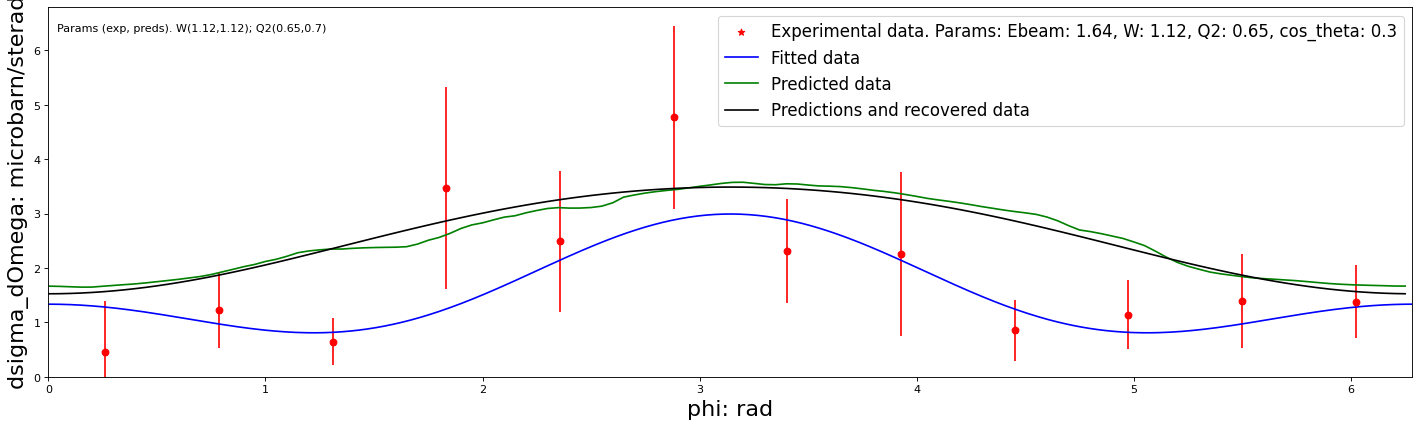

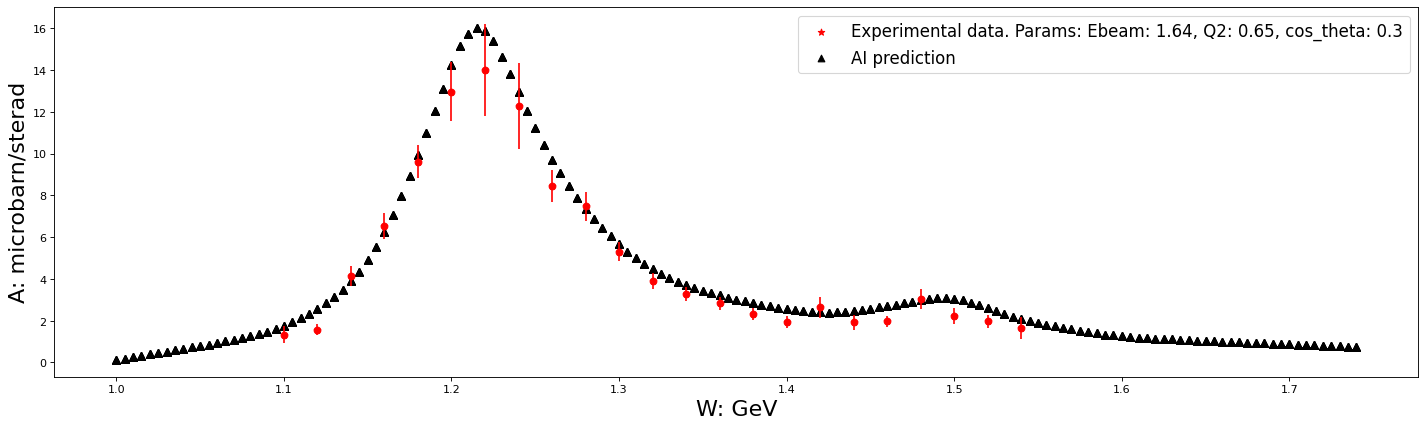

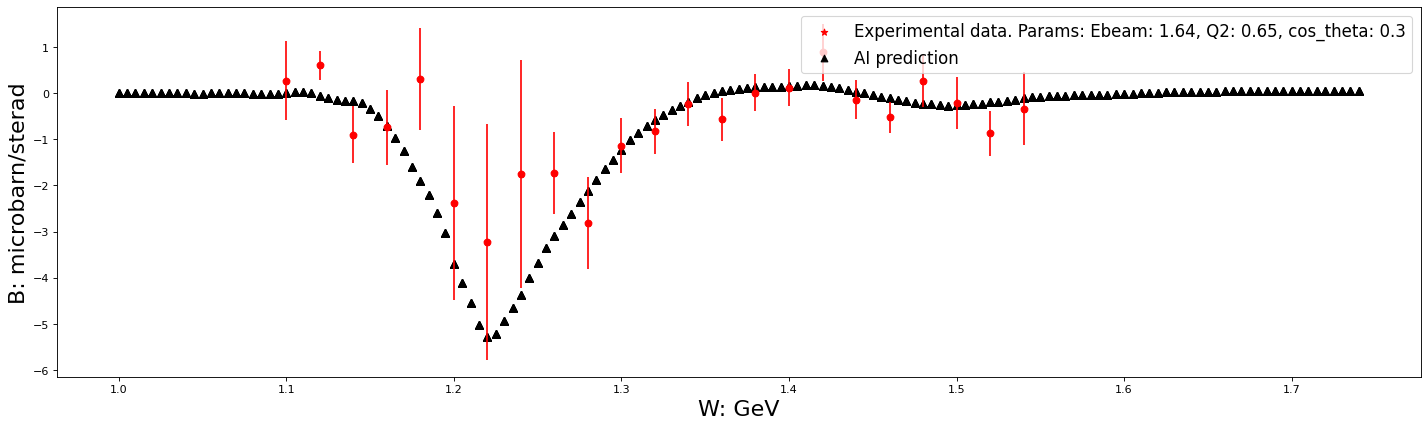

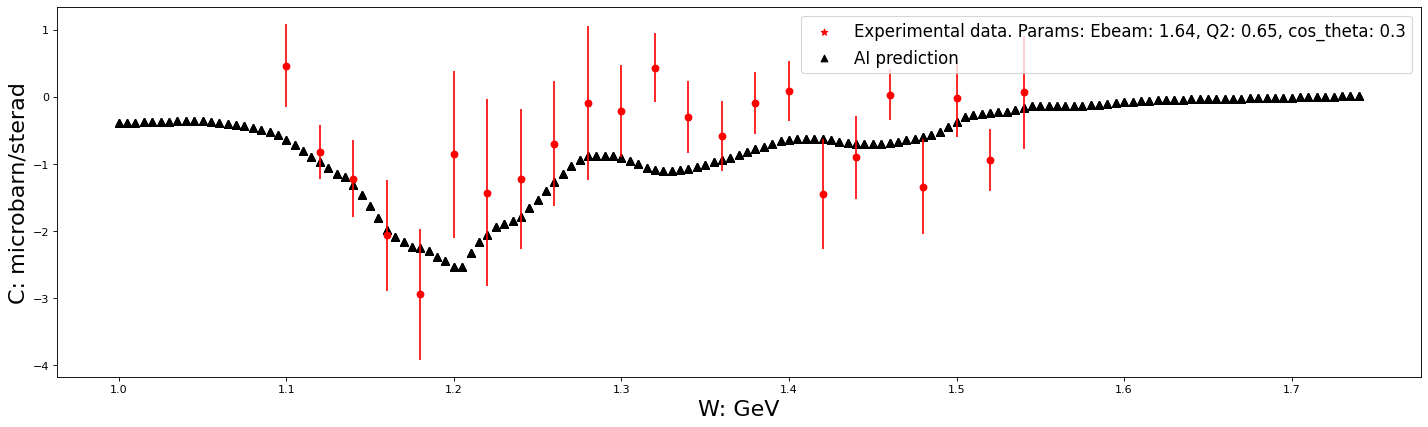

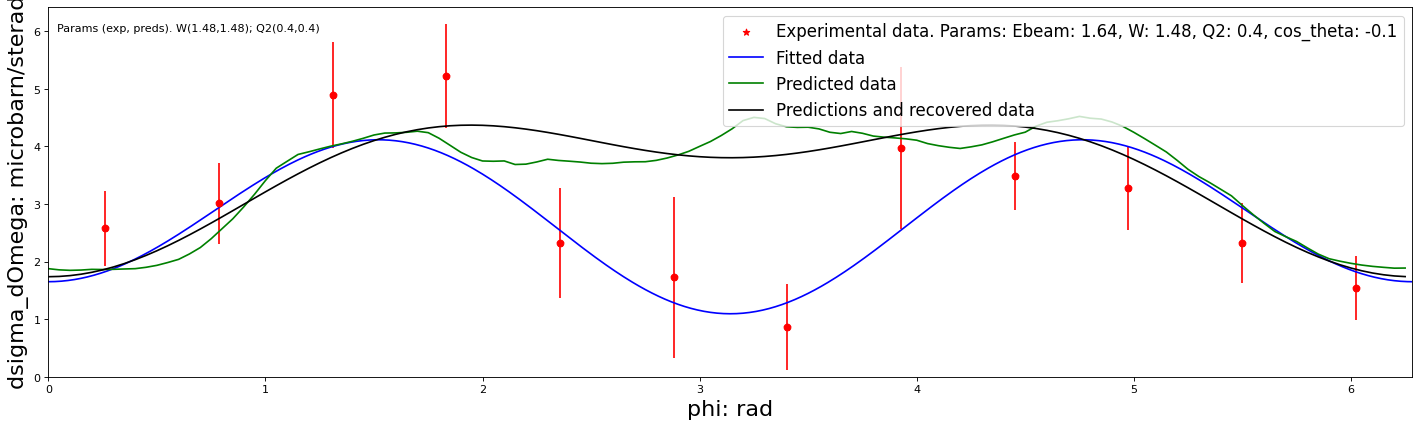

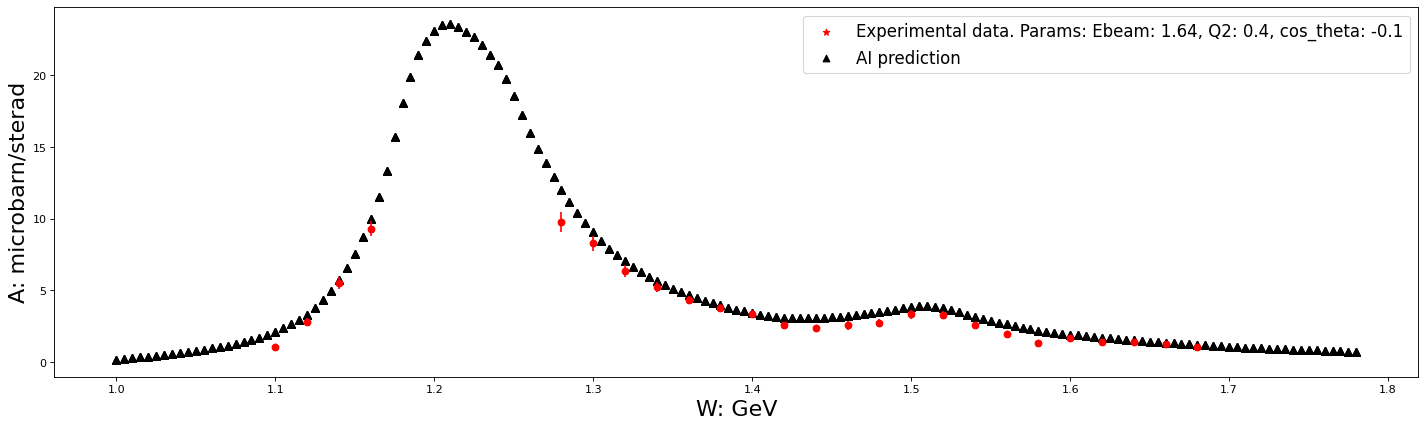

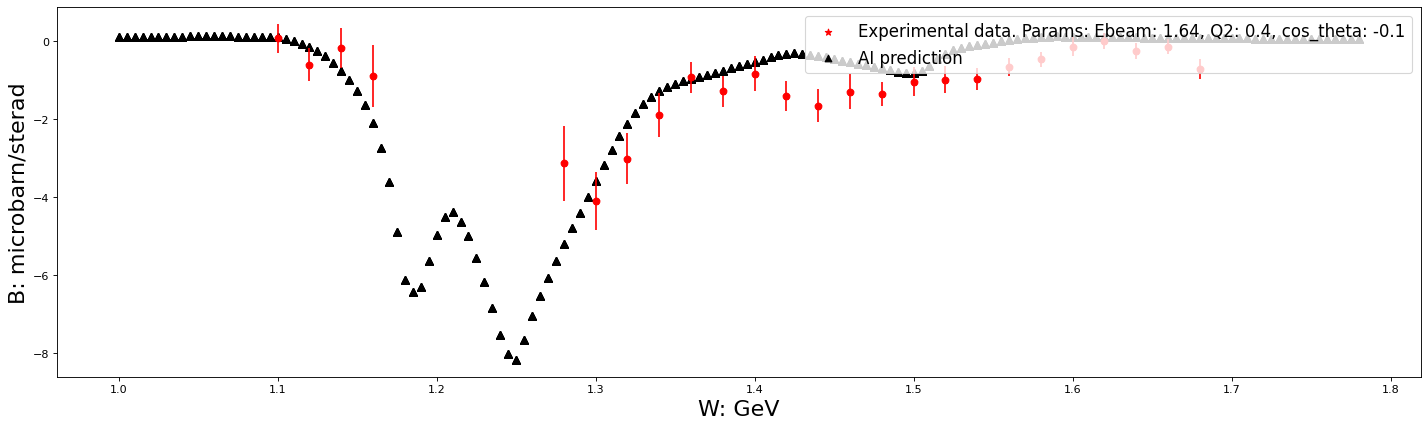

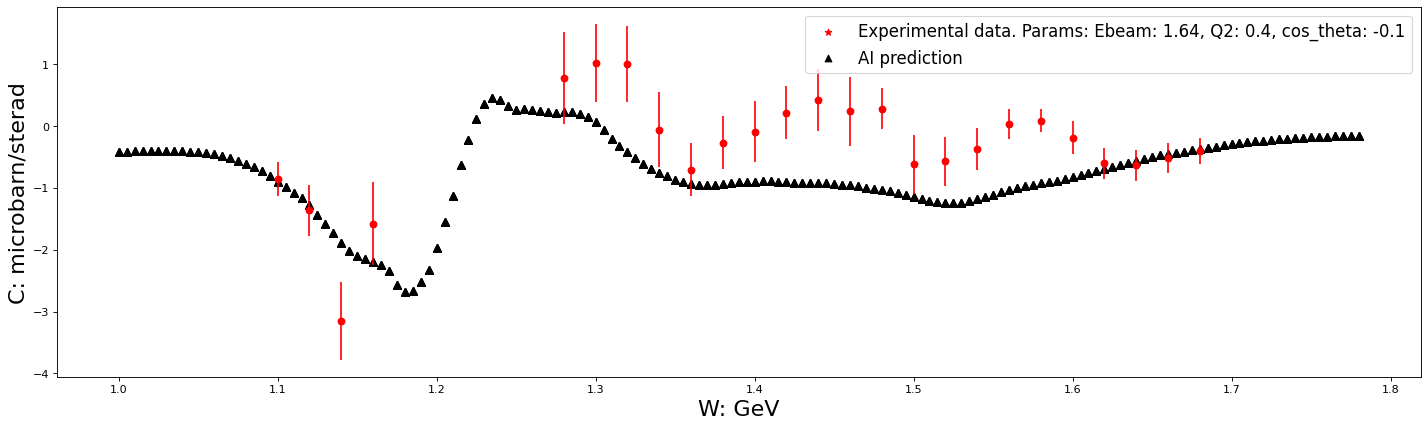

100%|██████████| 157/157 [00:06<00:00, 23.48it/s]
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/49455 [00:00<?, ?it/s]<ipython-input-11-3a0b5e42a48b>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.4943041673829124' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-11-3a0b5e42a48b>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.047472139468374225' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-in

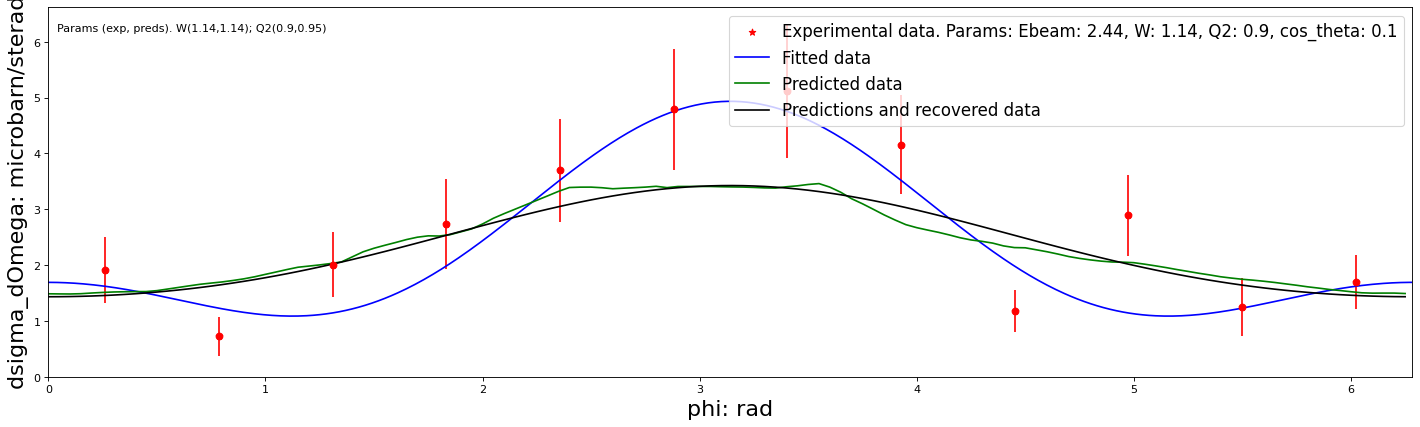

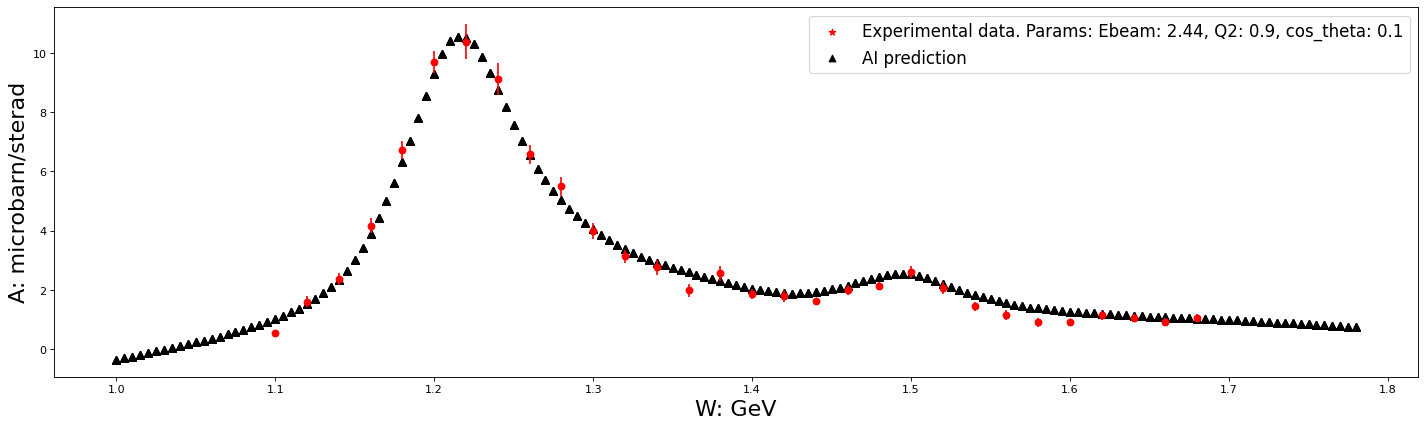

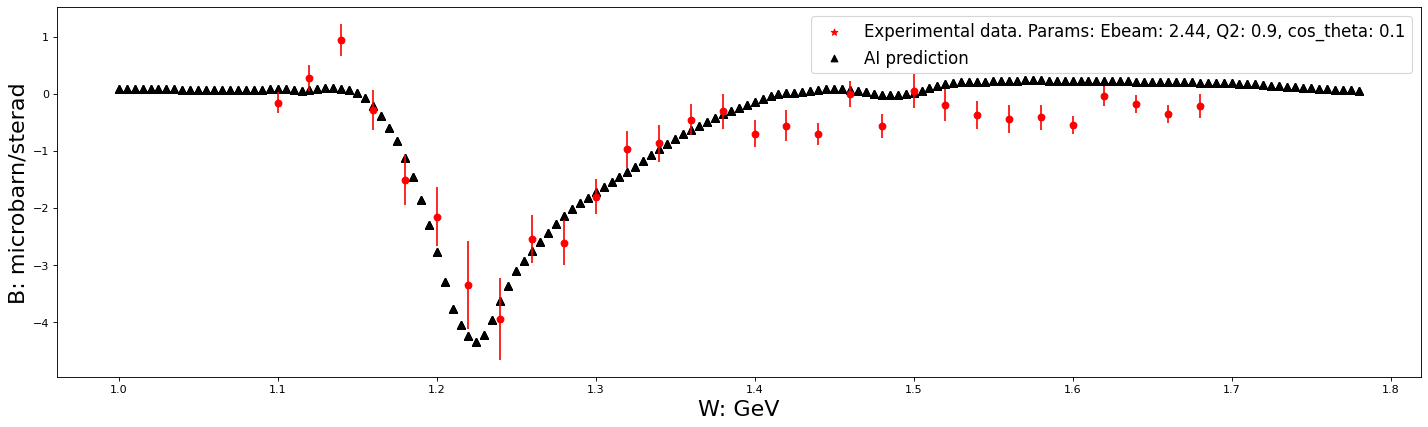

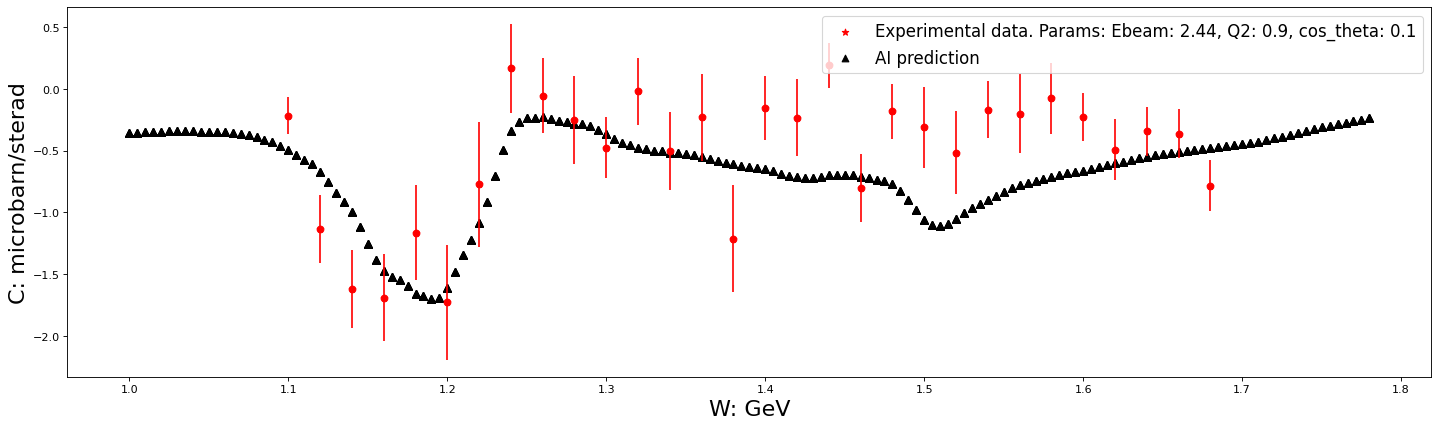

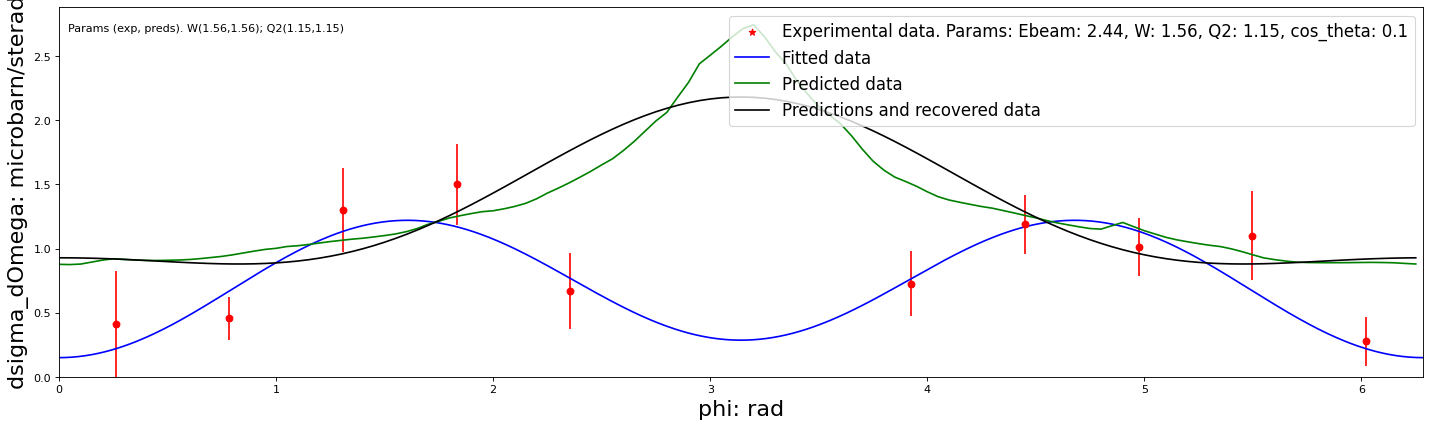

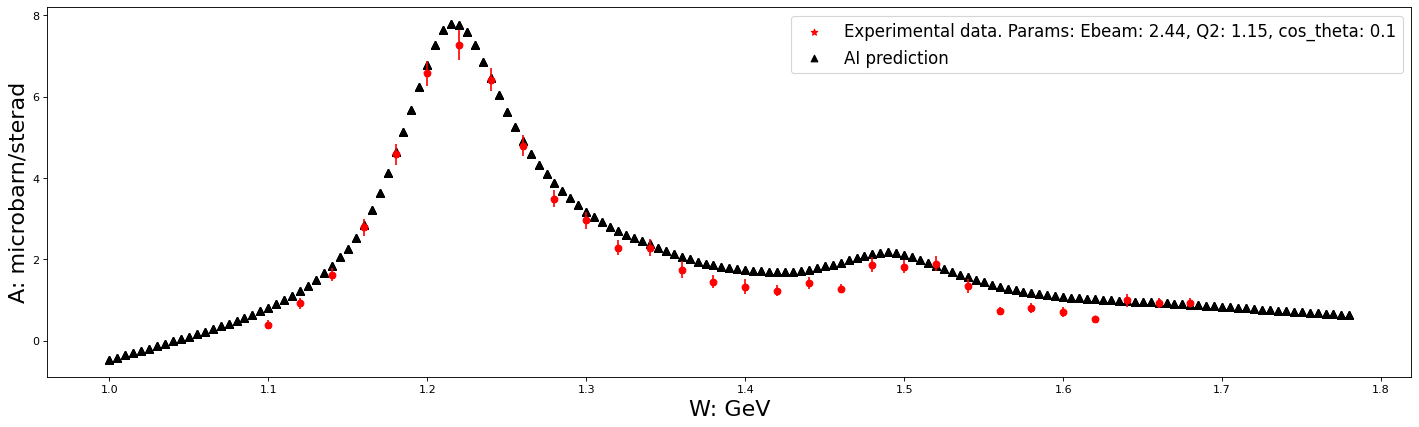

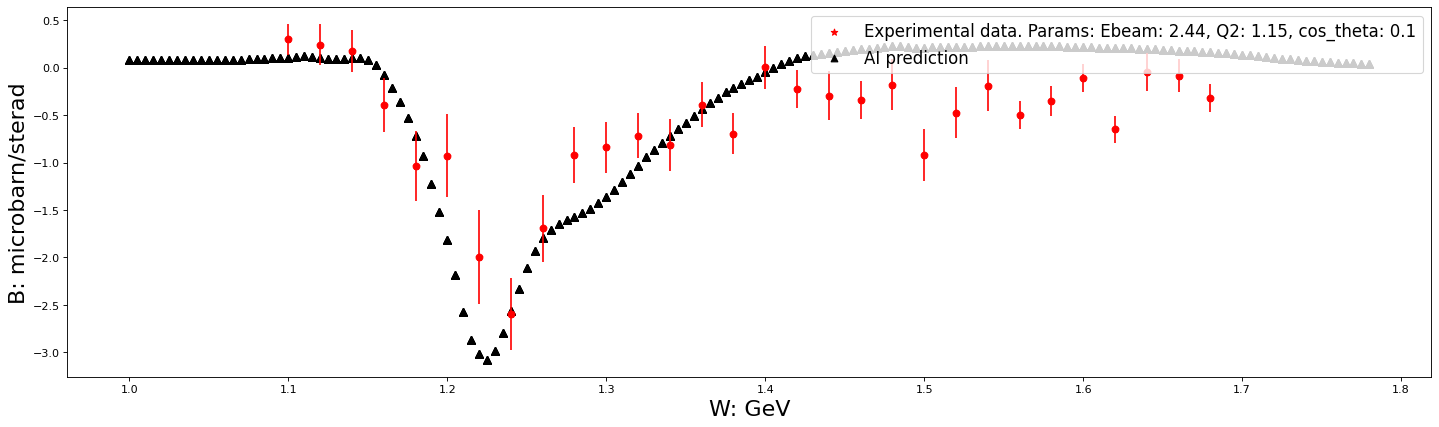

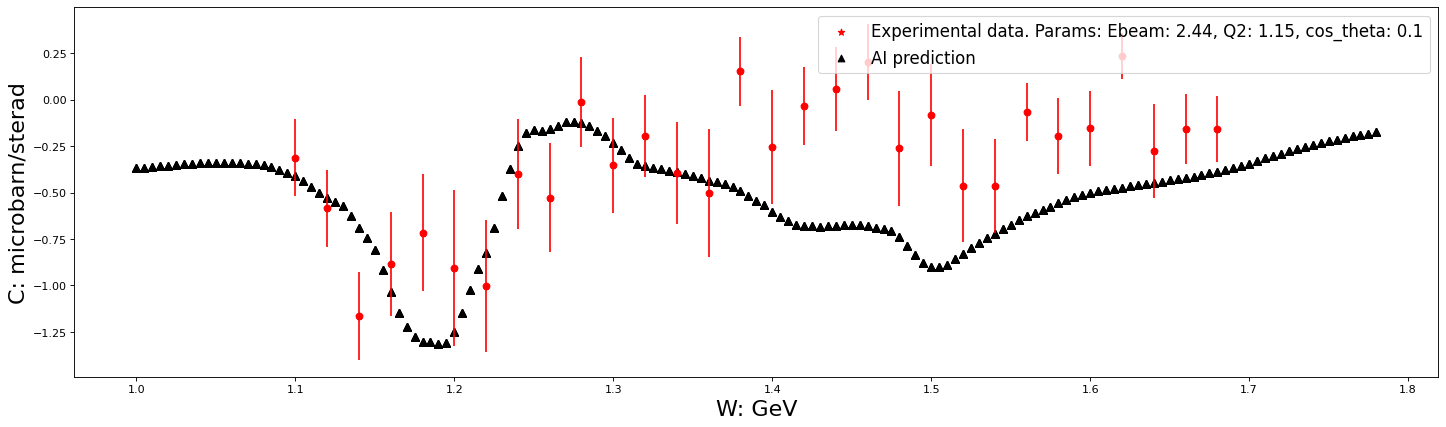

100%|██████████| 97/97 [00:08<00:00, 11.81it/s]
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/67221 [00:00<?, ?it/s]<ipython-input-11-3a0b5e42a48b>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.31709680664170103' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-11-3a0b5e42a48b>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.05570602734702787' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-inp

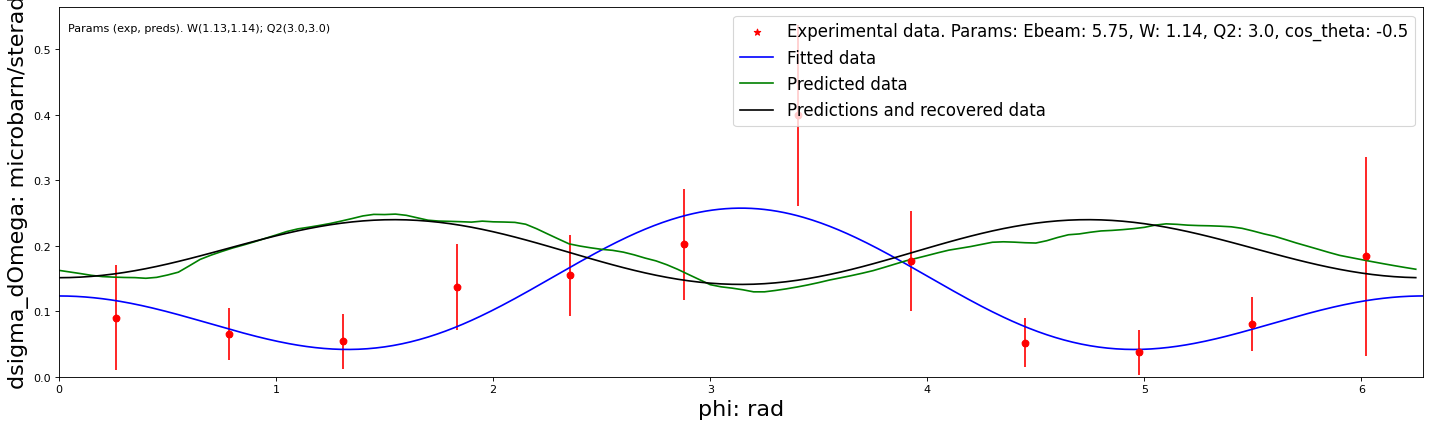

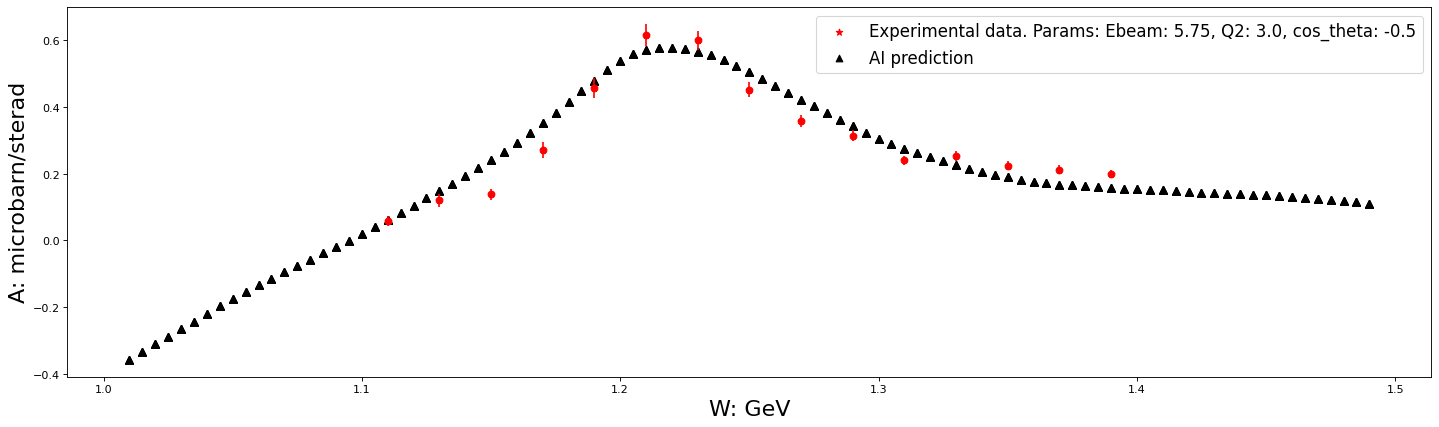

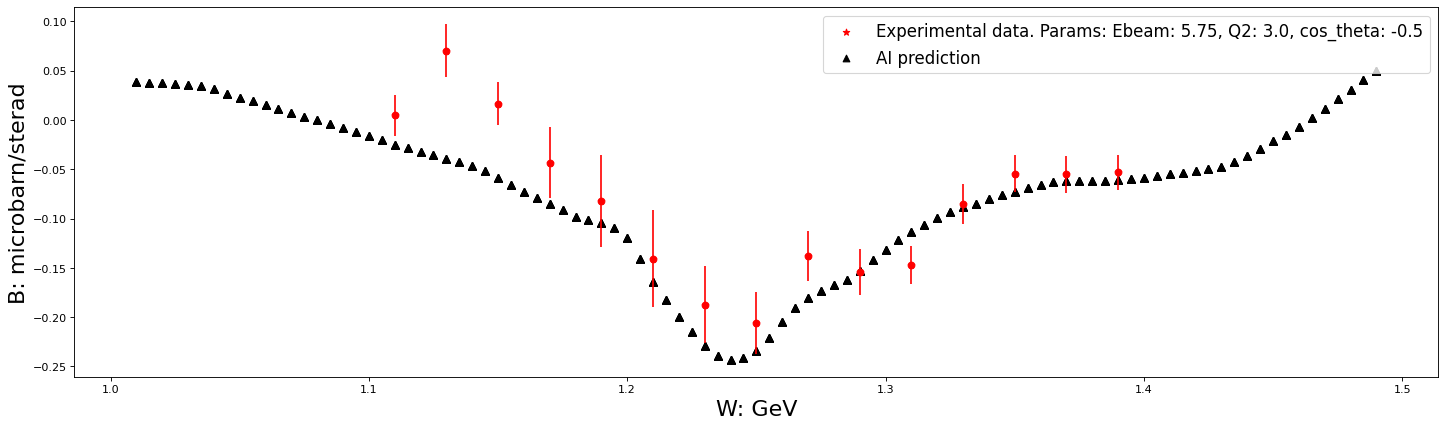

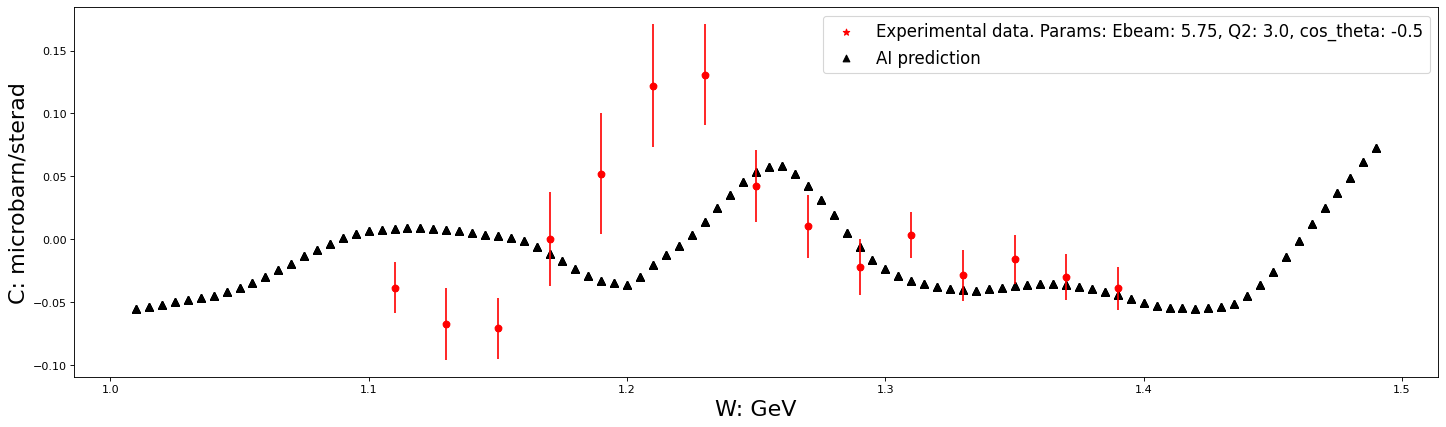

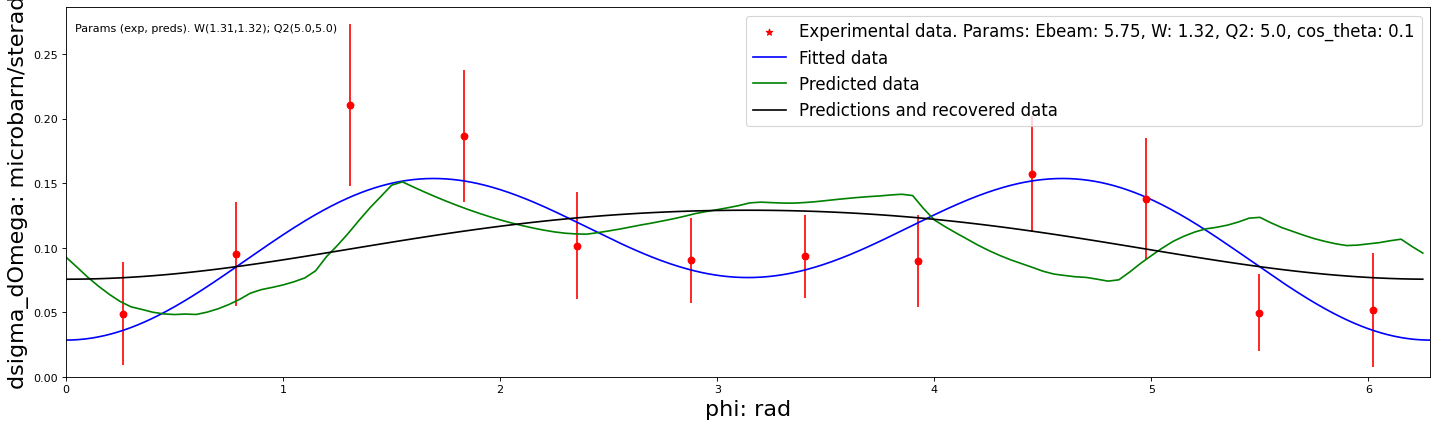

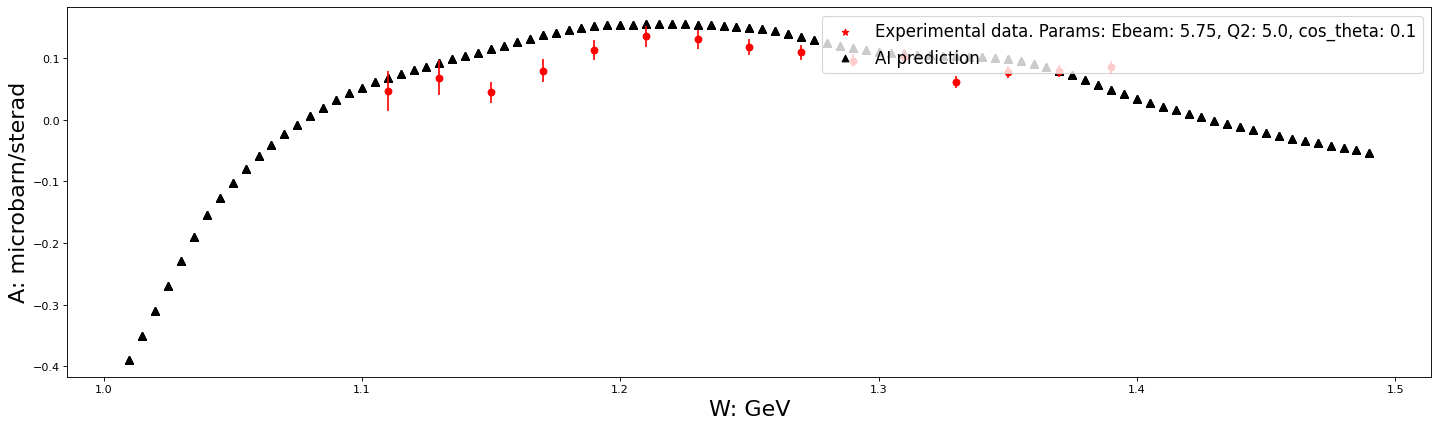

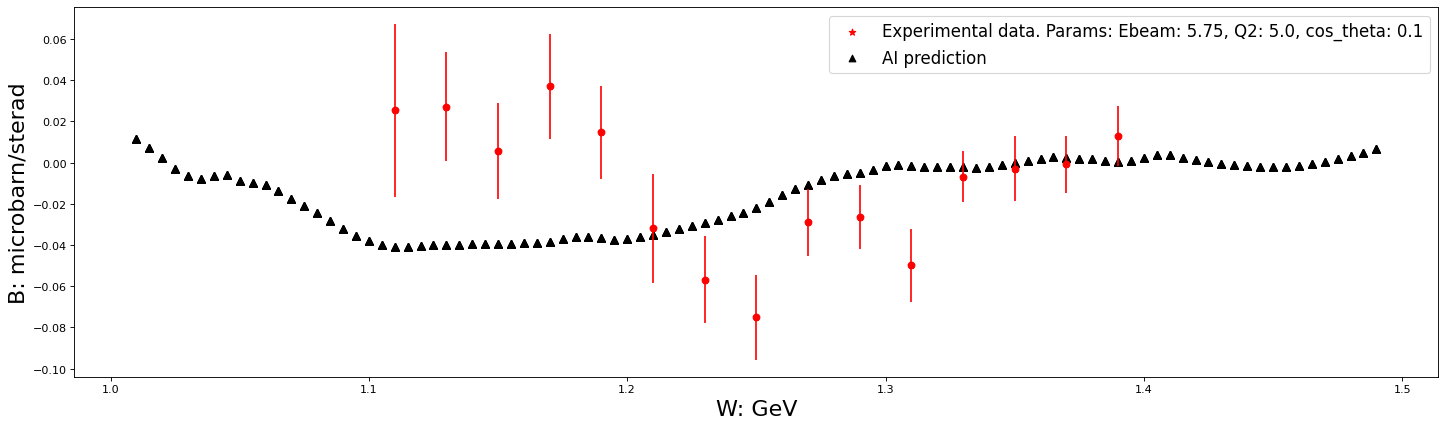

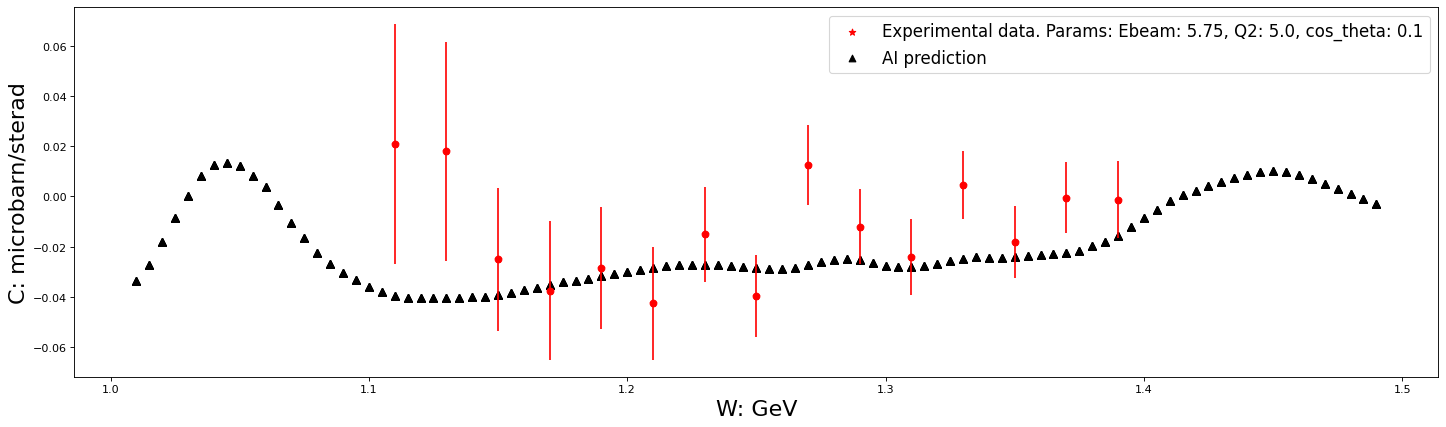

100%|██████████| 177/177 [00:03<00:00, 48.41it/s]
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/33453 [00:00<?, ?it/s]<ipython-input-11-3a0b5e42a48b>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.8078759892849606' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-11-3a0b5e42a48b>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.040594360202627265' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-in

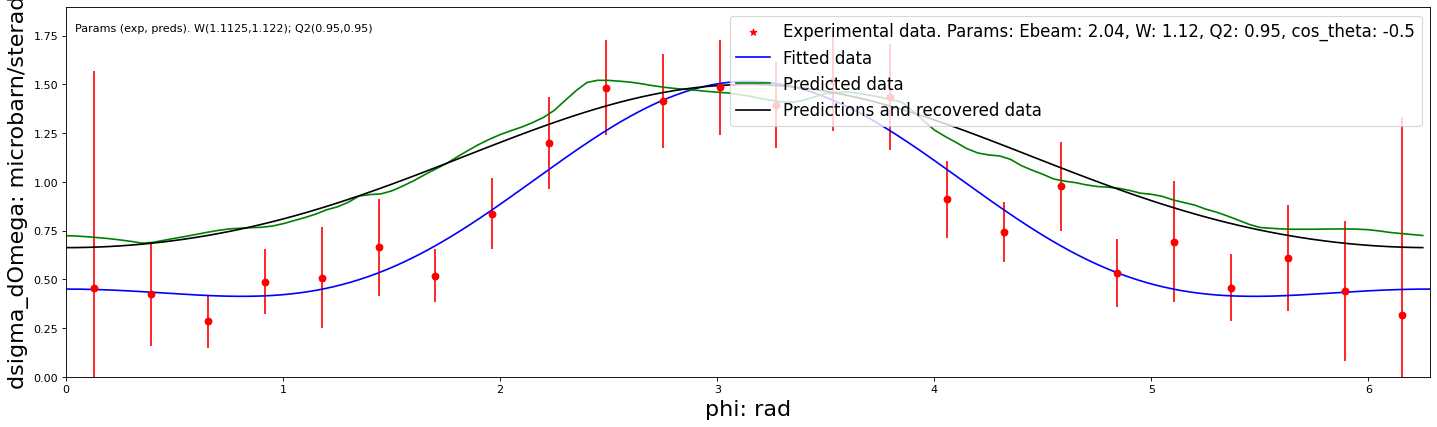

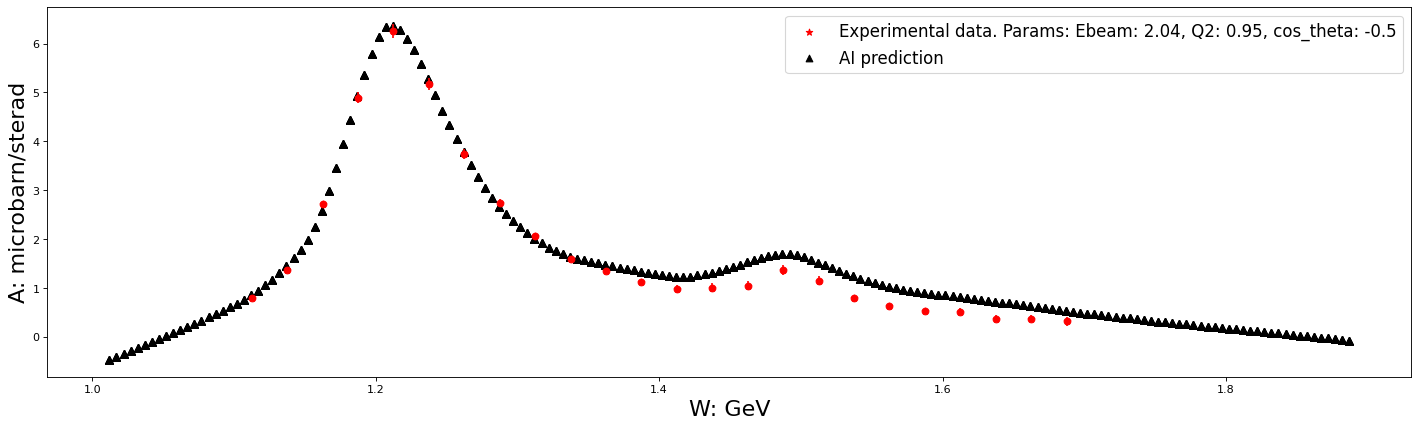

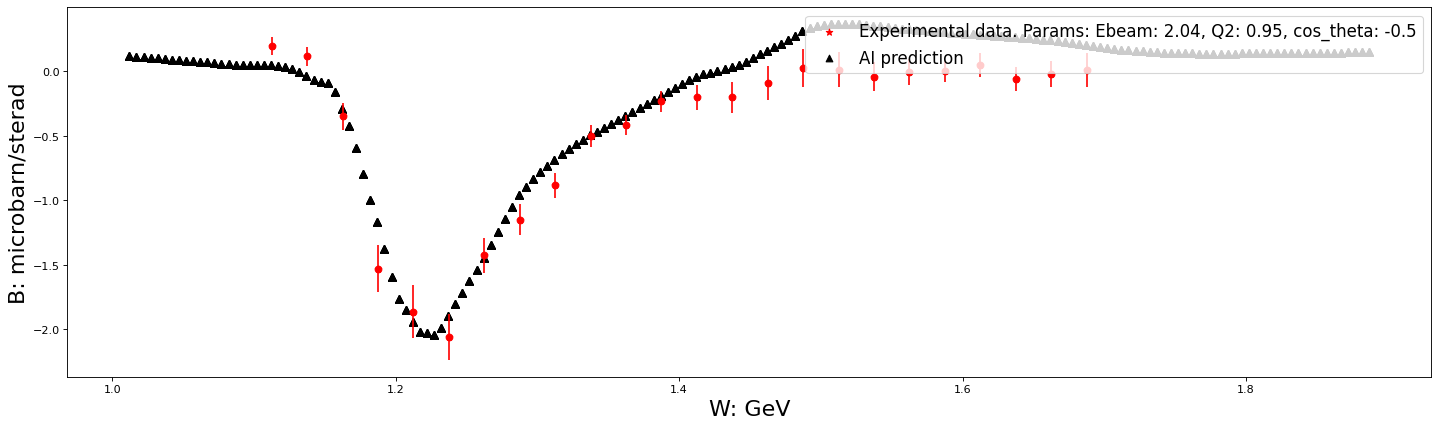

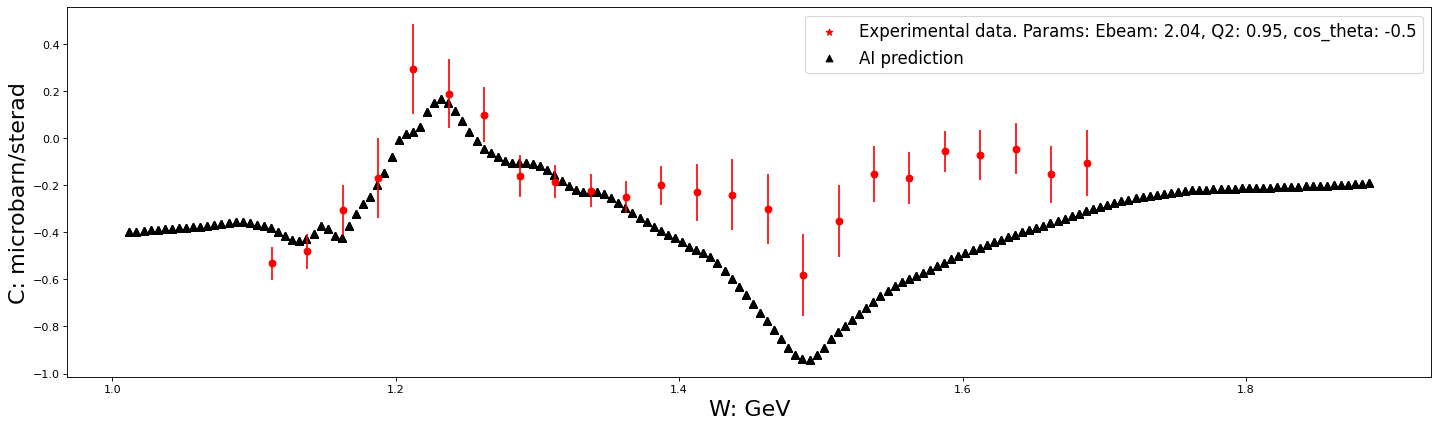

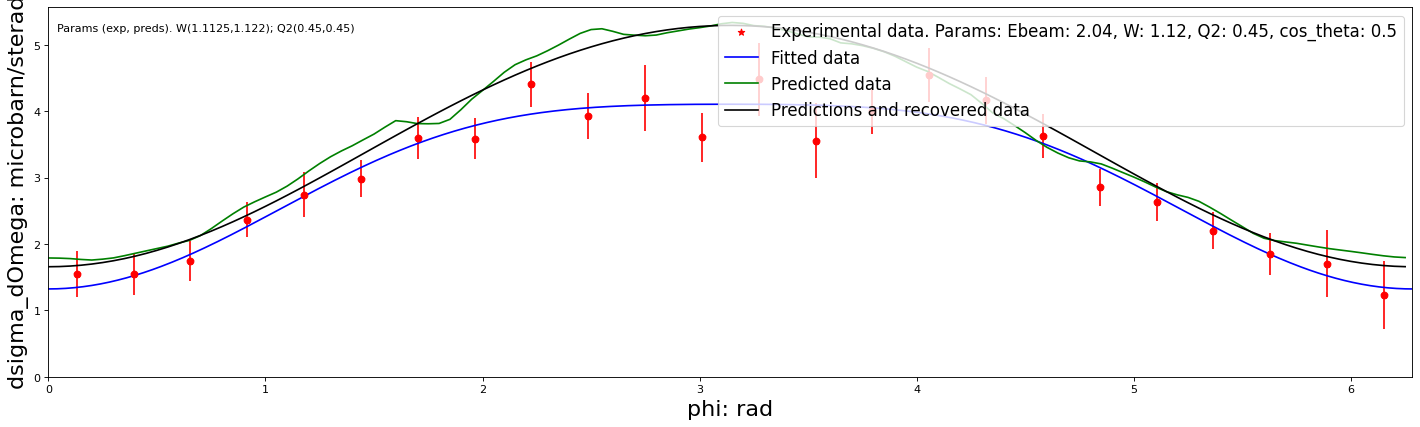

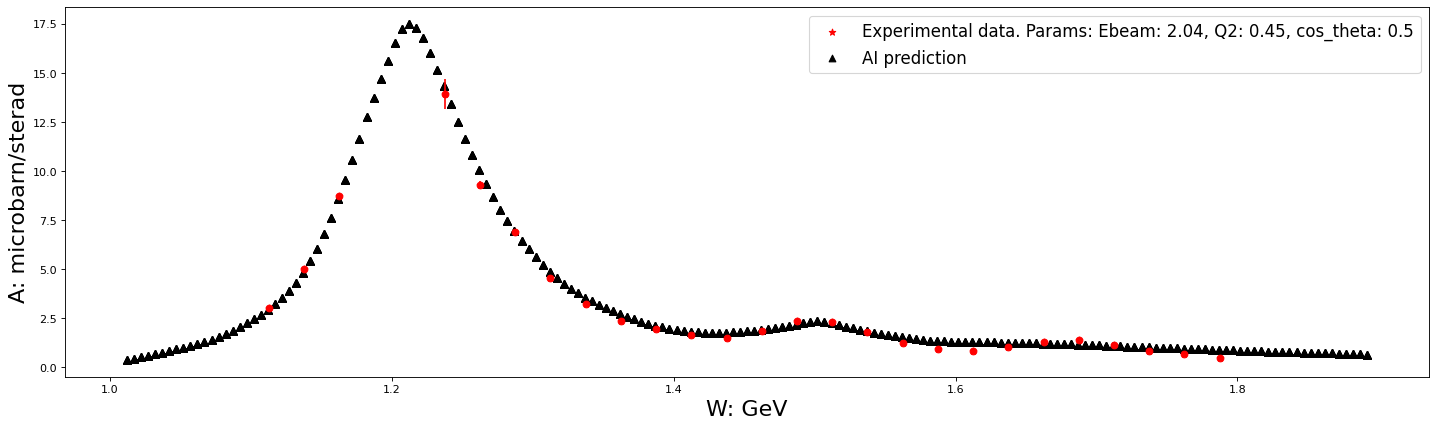

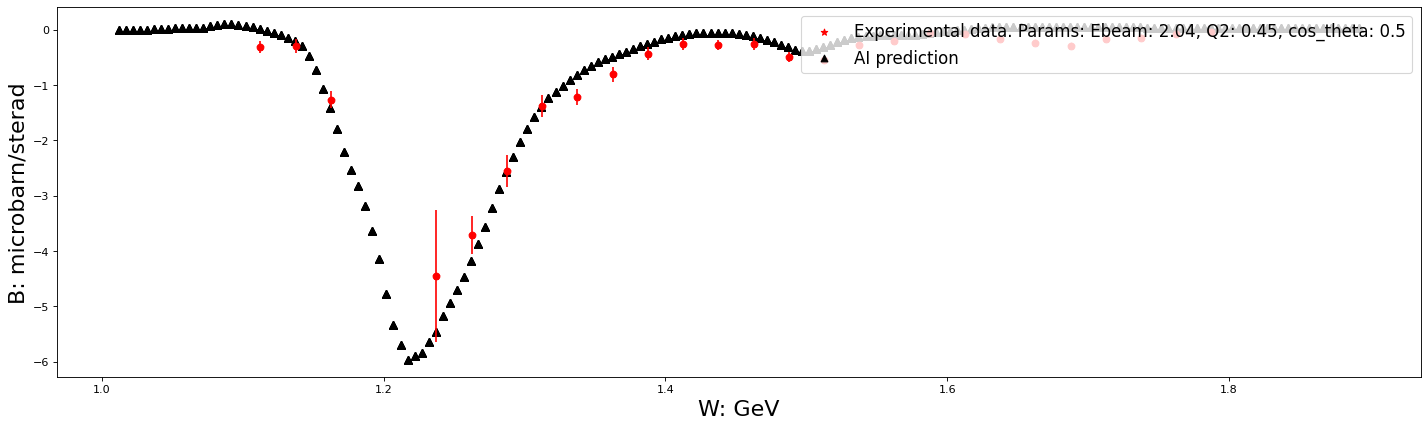

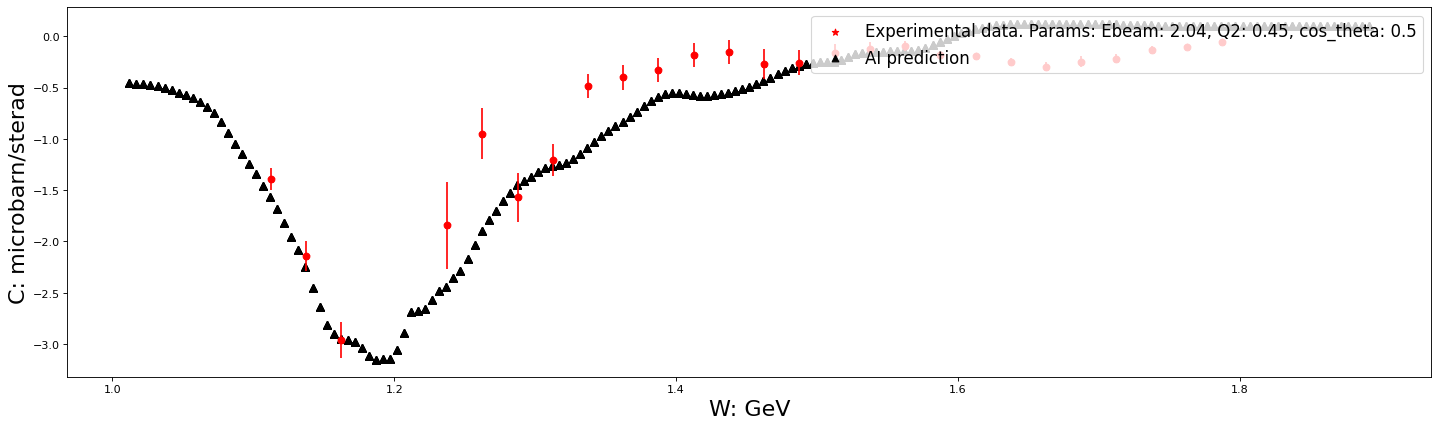

In [13]:
def plot_cross_section_and_sf(Ebeam, W, Q2, cos_theta, df_grid, df_sf):
    plot_joint_cross_sections(df, Ebeam, W, Q2, cos_theta, df_grid)
    plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='A', func_error='A_error')
    plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='B', func_error='B_error')
    plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='C', func_error='C_error')
    return None

for Ebeam in [1.64, 2.44, 5.75, 2.04]:
    os.makedirs(f"/content/NN/E_beam={Ebeam}", exist_ok=True)
    df_grid = generate_grid_df(Ebeam)
    df_sf = generate_df_sf(Ebeam)

    W = list(df_for_plot[df_for_plot.Ebeam == Ebeam].W)[0]
    Q2 = list(df_for_plot[df_for_plot.Ebeam == Ebeam].Q2)[0]
    cos_theta = list(df_for_plot[df_for_plot.Ebeam == Ebeam].cos_theta)[0]
    plot_cross_section_and_sf(Ebeam, W, Q2, cos_theta, df_grid, df_sf)

    W = list(df_for_plot[df_for_plot.Ebeam == Ebeam].W)[1]
    Q2 = list(df_for_plot[df_for_plot.Ebeam == Ebeam].Q2)[1]
    cos_theta = list(df_for_plot[df_for_plot.Ebeam == Ebeam].cos_theta)[1]
    plot_cross_section_and_sf(Ebeam, W, Q2, cos_theta, df_grid, df_sf)

In [14]:
# Log results to W&B Media

# for root, dirs, files in os.walk(os.path.abspath("/content/NN")):
#     for file in files:
#         path_to_img = os.path.join(root, file)
#         im = plt.imread(path_to_img)
#         wandb.log({"img": [wandb.Image(path_to_img)]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.65_W=1.12_cos_theta=0.3.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.65_cos_theta=0.3.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.65_cos_theta=0.3.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.65_cos_theta=0.3.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.4_W=1.48_cos_theta=-0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png')]})




wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.45_W=1.12_cos_theta=0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.45_cos_theta=0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.45_cos_theta=0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.45_cos_theta=0.5.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.95_W=1.12_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png')]})




wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=0.9_W=1.14_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=0.9_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=1.15_W=1.56_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=1.15_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/B_E_beam=2.44_Q2=1.15_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=1.15_cos_theta=0.1.png')]})




wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=3.0_W=1.14_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=5.0_W=1.32_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=5.0_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=5.0_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=5.0_cos_theta=0.1.png')]})

2025-02-08 08:01:02,508 : DEBUG : STREAM b'IHDR' 16 13
2025-02-08 08:01:02,510 : DEBUG : STREAM b'tEXt' 41 58
2025-02-08 08:01:02,512 : DEBUG : STREAM b'pHYs' 111 9
2025-02-08 08:01:02,514 : DEBUG : STREAM b'IDAT' 132 65536
2025-02-08 08:01:02,541 : DEBUG : Starting new HTTPS connection (1): api.wandb.ai:443
2025-02-08 08:01:02,610 : DEBUG : https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None
2025-02-08 08:01:02,672 : DEBUG : https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None
2025-02-08 08:01:02,677 : DEBUG : STREAM b'IHDR' 16 13
2025-02-08 08:01:02,682 : DEBUG : STREAM b'tEXt' 41 58
2025-02-08 08:01:02,684 : DEBUG : STREAM b'pHYs' 111 9
2025-02-08 08:01:02,687 : DEBUG : STREAM b'IDAT' 132 65536
2025-02-08 08:01:02,711 : DEBUG : STREAM b'IHDR' 16 13
2025-02-08 08:01:02,714 : DEBUG : STREAM b'tEXt' 41 58
2025-02-08 08:01:02,717 : DEBUG : STREAM b'pHYs' 111 9
2025-02-08 08:01:02,720 : DEBUG : STREAM b'IDAT' 132 38011
2025-02-08 08:01:02,744 : DEBUG : STREAM b'IHDR' 16 13
2

In [15]:
# Log results to W&B Artifacts

wandb_table = wandb.Table(columns=["Ebeam", "cross section","A","B","C"])


for root, dirs, files in os.walk(os.path.abspath("/content/NN//E_beam=1.64")):
    wandb_table.add_data('E_beam=1.64', wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.65_W=1.12_cos_theta=0.3.png'),
                         wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.65_cos_theta=0.3.png'),
                         wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.65_cos_theta=0.3.png'),
                         wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.65_cos_theta=0.3.png'))

    wandb_table.add_data('E_beam=1.64', wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.4_W=1.48_cos_theta=-0.1.png'),
                         wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png'),
                         wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png'),
                         wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png'))



for root, dirs, files in os.walk(os.path.abspath("/content/NN/E_beam=2.04")):
    wandb_table.add_data('E_beam=2.04', wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.45_W=1.12_cos_theta=0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.45_cos_theta=0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.45_cos_theta=0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.45_cos_theta=0.5.png'))

    wandb_table.add_data('E_beam=2.04', wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.95_W=1.12_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png'))



for root, dirs, files in os.walk(os.path.abspath("/content/NN/E_beam=2.44")):
    wandb_table.add_data('E_beam=2.44', wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=0.9_W=1.14_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=0.9_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png'))

    wandb_table.add_data('E_beam=2.44', wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=1.15_W=1.56_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=1.15_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/B_E_beam=2.44_Q2=1.15_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=1.15_cos_theta=0.1.png'))



for root, dirs, files in os.walk(os.path.abspath("/content/NN/E_beam=5.75")):
    wandb_table.add_data('E_beam=5.75', wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=3.0_W=1.14_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png'))

    wandb_table.add_data('E_beam=5.75', wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=5.0_W=1.32_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=5.0_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=5.0_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=5.0_cos_theta=0.1.png'))



# Create a wandb Artifact
artifact = wandb.Artifact(name="plots", type="data")
# Add the table to the artifact
#artifact.add(wandb.Image(path_to_img), "plots_E_beam={Ebeam}")
artifact.add(wandb_table, f"plots")
# Log the artifact
wandb.log_artifact(artifact)

2025-02-08 08:01:05,052 : DEBUG : STREAM b'IHDR' 16 13
2025-02-08 08:01:05,058 : DEBUG : STREAM b'tEXt' 41 58
2025-02-08 08:01:05,062 : DEBUG : STREAM b'pHYs' 111 9
2025-02-08 08:01:05,065 : DEBUG : STREAM b'IDAT' 132 65536
2025-02-08 08:01:05,098 : DEBUG : STREAM b'IHDR' 16 13
2025-02-08 08:01:05,105 : DEBUG : STREAM b'tEXt' 41 58
2025-02-08 08:01:05,107 : DEBUG : STREAM b'pHYs' 111 9
2025-02-08 08:01:05,109 : DEBUG : STREAM b'IDAT' 132 38011
2025-02-08 08:01:05,124 : DEBUG : STREAM b'IHDR' 16 13
2025-02-08 08:01:05,127 : DEBUG : STREAM b'tEXt' 41 58
2025-02-08 08:01:05,129 : DEBUG : STREAM b'pHYs' 111 9
2025-02-08 08:01:05,132 : DEBUG : STREAM b'IDAT' 132 36329
2025-02-08 08:01:05,151 : DEBUG : STREAM b'IHDR' 16 13
2025-02-08 08:01:05,153 : DEBUG : STREAM b'tEXt' 41 58
2025-02-08 08:01:05,158 : DEBUG : STREAM b'pHYs' 111 9
2025-02-08 08:01:05,161 : DEBUG : STREAM b'IDAT' 132 36783
2025-02-08 08:01:05,183 : DEBUG : STREAM b'IHDR' 16 13
2025-02-08 08:01:05,185 : DEBUG : STREAM b'tEXt' 

<Artifact plots>

In [16]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr_scheduler_monitoring,██████▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mae,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▇██████████████████████████████████████
train_rmse,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_loss,█▃▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mae,█▄▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [ ]:
# #for random choice cross sections and structure functions
# os.makedirs(f"/content/NN/cross_sections", exist_ok=True)
# os.makedirs(f"/content/NN/structure_functions", exist_ok=True)
# for Ebeam in [1.64, 2.44, 5.75, 2.04]:
#     df_grid = generate_grid_df(Ebeam)
#     df_sf = generate_df_sf(Ebeam)
#     step = 0
#     while step != 2:
#         picture_is_not_drawn = True
#         while picture_is_not_drawn:
#             Q2 = random.choice(df[df.Ebeam==Ebeam].Q2.unique())
#             W = random.choice(df[(df.Ebeam==Ebeam) & (df.Q2==Q2)].W.unique())
#             cos_theta = random.choice(df[(df.Ebeam==Ebeam) & (df.Q2==Q2) & (df.W==W)].cos_theta.unique())
#             try:
#                 plot_joint_cross_sections(df, Ebeam, W, Q2, cos_theta, df_grid)
#             except:
#                 print(Ebeam, W, Q2, cos_theta)
#             else:
#                 plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='A', func_error='A_error')
#                 plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='B', func_error='B_error')
#                 plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='C', func_error='C_error')
#                 step += 1
#                 picture_is_not_drawn = False